# <font color='red'><ins>Práctica 3 FAA - Clasificación mediante Algoritmos Genéticos</ins></font>
## Alejandro Santorum Varela - alejandro.santorum@estudiante.uam.es
## José Manuel Chacón Aguilera - josem.chacon@estudiante.uam.es

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [3]:
# My modules
from Datos import Datos
import EstrategiaParticionado
import Clasificador

# External modules
import numpy as np
import random
import pickle
import time
import matplotlib.pyplot as plt

# Important to pre-install tabulate (pip install tabulate)
from tabulate import tabulate

# Init class Classifier
clasificador = Clasificador.Clasificador()

# <font color='red'>0. Cambios en Datos.py </font>

Se han realizado algunos cambios en la clase Datos para adaptarla a las necesidades de esta práctica. Para ser más concretos, se ha añadido un nuevo parámetro al constructor **col_custom_dtypes** y un nuevo método (estático) **encodeDatos(datos)**.

## <font color='blue'> 0.1 Nueva opción de lectura: parámetro col_custom_dtypes </font>

El constructor de la clase Datos ahora recibe un nuevo parámetro opcional, **col_custom_dtypes**, que por defecto es None, pero que si se requiere es pasado a la función de lectura *read_csv* de la librería Pandas. Este parámetro es un diccionario, donde la clave es el nombre de un atributo del fichero de datos ('Pclass' del fichero titanic.data) y el valor es el tipo que será asignado a ese atributo.

Para mayor información, uno puede analizar la documentación de la propia librería Pandas (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), en especial el argumento **dtype**.

En las anteriores prácticas considerabamos que el tipo del atributo 'class' era **siempre nominal por defecto**. Gracias a este cambio, ahora podemos trabajar con **clases continuas** e indicar que la clase es nominal **solo** cuando lo deseemos simplemente usando el parámetro **col_custom_dtypes={'class':str}**.

En la práctica que nos ocupa, como queremos cosiderar todos los atributos como nominales el parámetro col_custom_dtypes será **col_custom_dtypes={'Pclass':str, 'Age':str, 'Class':str}** (la clase 'Sex' ya es nominal por defecto).

## <font color='blue'> 0.2 Método estático encodeDatos(datos) </font>

En las práctica 1 ya habíamos necesitado utilizar la codificación One-Hot de los datos para ejecutar Naive-Bayes con la librería SKLearn. En esta práctica vamos a necesitar transformar el conjunto de datos a una codificación únicamente binaria, por lo que necesitaremos de nuevo la codificación One-Hot.

Debido a que será regular usar esta codificación, la función de transformación de datos se ha incorporado a la clase Datos. Como esta función (a partir de ahora método) no depende de la instancia de Datos con la que estemos trabajando, lo implementaremos como un método estático.

**encodeDatos(datos)** recibe un numpy array de tamaño (no. de atributos + 1(clase) ) x (número de ejemplos) y devuelve otro numpy array bidimensional de tamaño k x (número de ejemplos), donde k depende de la cantidad de valores diferentes de los atributos.

Como en esta práctica trabajaremos completamente con el conjunto de datos codificado, la mejor forma de usar este método será:
~~~
db_titanic = Datos('../ConjuntosDatos/titanic.data', col_custom_dtypes={'Pclass':str, 'Age':str, 'Class':str})
db_titanic.datos = Datos.encodeDatos(db_titanic.datos)
~~~

# <font color='red'>1. Detalles de la implementación </font>

Lo primero, vamos a exponer los posibles parámetros del constructor de la clase AlgoritmoGenético (aunque estos comentarios también están incluidos en el código).

~~~
__init__(self, n_population=100, max_rules=5, nepochs=100, cross_prob=0.7, cross_strat='both',
         bitflip_prob=None, add_rule_prob=0.3, elite_perc=0.05, shuffle_rules=False, verbose=False)
~~~
- **n_population**: tamaño de la población, que se mantendrá fija durante todas las épocas.
- **max_rules**: número máximo de reglas de un individuo de la población.
- **nepochs**: número de épocas, es decir, número de generaciones de la evolución.
- **cross_prob**: probabilidad de cruce. Dos individuos tienen una probabilidad 'cross_prob' de cruzarse en una época dada.
- **cross_strat**: estrategia de cruce. Existen las siguientes estrategias de cruce posibles:
    - cross_strat='inter': se realiza un cruce inter-reglas, es decir, los individuos son cruzados por reglas sin romper ninguna de ellas.
    - cross_strat='intra': se realiza un cruce intra-reglas, es decir, los individuos pueden cruzarse en el medio de dos reglas (una de cada uno) en el mismo índice.
    - cross_strat='both': se realiza tanto el cruce inter-reglas como el intra-regla.
    - cross_strat='uniform': se realiza un cruce que mezcla la estrategia de cruce uniforme con la técnica de selección de descendientes conocida como 'torneo'. Se explicará más en detalle en la sección dónde se explican los cruces.
- **bitflip_prob**: probabilidad de que un bit de una regla mute. Si bitflip_flip=None, en el entrenamiento esta probabilidad es calculada para que sea igual a 1/(tamaño de las reglas) para que se mute un bit por regla *en media*.
- **add_rule_prob**: probabilidad de que se añada una regla aleatoria nueva a un individuo en el momento de la mutación. Adicionalmente, un individuo tiene también probabilidad 'add_rule_prob' de perder una regla (si tiene más de una). Finalmente, un individuo no se le añade ni se le quita ninguna regla con probabilidad 1 - 2·add_rule_prob, por lo que hemos restringido el parámetro 'add_rule_prob' a que sea menor de 0'5.
- **elite_perc**: porcentaje de elitismo, es decir, porcentaje de la población con mejor *fitness* que pasa a la siguiente época directamente. En esta práctica este parámetro será únicamente 0'05.
- **shuffle_rules**: Booleano que determina si el orden de las reglas de un individuo ha de tenerse en cuenta o no. Siendo más precisos, cuando se realiza un cruce de dos individuos, el orden de las reglas determina el conjunto de posibles descendientes si no se embaraja el conjunto de reglas de los individuos. Si 'shuffle_rules' es True, las reglas de los padres son embarajadas antes del cruce, por lo que la cantidad de hijos posibles tras el cruce es mayor.
- **verbose**: Booleano que determina si se muestra la salida del fitness medio de la población y del fitness del mejor individuo por época. Por defecto está a False.


El **ALGORITMO DE ENTRENAMIENTO** implementado está basado en el algoritmo expuesto en clase de teoría y lo podemos resumir en los siguientes pasos (para mayor nivel de detalle visitar el fichero **Clasificador.py**, que viene ampliamente comentado):
1. **Cálculo de los priores**, que nos serán útiles para la **fase de clasificación** (explicado más adelante).
2. **Cálculo de bitflip_prob** si está a None.
3. **Inicialización de la población inicial**, donde se tiene en cuenta el tamaño de la población, el tamaño fijo de cada regla, el número máximo de reglas y que no puede haber reglas con todos los bits a 1 ni todos los bits 0.
4. Para **i=0 hasta nepochs**:
5. **Cálculo del *fitness* de cada individuo de la población**, guardándolo en una lista para no tener que recalcularlo en toda la época.
6. **Selección de la élite**, es decir, el 5% de individuos con mejor fitness.
7. Selección de padres: **selección proporcional a *fitness*** (ruleta) entre todos los individuos de la población, incluyendo los individuos élite. El número de padres seleccionados es ceil(0.95 · *n_population*), ya que el número de individuos seleccionados por el elitismo es floor(0.05 · *n_population*) y recordemos que al final de cada época el tamaño de la población tiene que permanecer constante.
8. Los individuos seleccionados por la ruleta (entre los cuales también pueden estar algunos de los individuos de la élite) se **cruzan siguiendo la/s estrategia/s de cruce seleccionada/s** y dependiendo de la probabilidad de cruce (*cross_prob*).
9. Los individuos resultantes del cruce **son mutados** dependiendo de la probabilidad de mutación (*bitflip_prob* y *add_rule_prob*)
10. Los individuos resultantes de la mutación son **juntados** a los individuos que fueron seleccionados por el elitismo, obteniéndose de nuevo un tamaño de población igual a *n_population* (invariante en toda la evolución).
11. Una vez se han desarrollado todas las épocas de la evolución, se **selecciona el mejor individuo** de la población (mayor *fitness*) y se guarda para su futuro uso en la clasificación de nuevos datos.

## <font color='blue'> 1.1 Generación población inicial </font>

El constructor del algoritmo 'AlgoritmoGenetico' recibe dos parámetros esenciales para la correcta generación de la población inicial: **n_population** y **max_rules**. El primero es el parámetro que indica el tamaño de la población inicial y que se mantendrá a lo largo de todas las épocas de evolución del algoritmo. El segundo indica el tamaño máximo de un individuo o solución,es decir, el número máximo de reglas de una solución. Este último parámetro es importante para evitar el sobreentrenamiento (*overfitting*) del modelo, ya que un número desorbitado de reglas produce que el algoritmo ajuste muy bien el conjunto de entrenamiento pero sea incapaz de generalizar el modelo para datos nuevos (conjunto de test). En esta práctica, se ha considerado que el número **máximo de reglas por individuo** tiene que oscilar entre **5 y 12**.

Con esto en mente, nos podemos centrar en la generación inicial del conjunto de individuos. Cada individuo es un conjunto de reglas, donde una regla es una cadena de ceros y unos que codifica una condición. El tamaño de la regla es constante, y se corresponde con el tamaño de un ejemplo del conjunto de datos **después** de ser codificado mediante *OneHotEncode* (incluyendo el bit de la clase) digamos **k bits**. Por lo tanto, para generar un nuevo individuo aleatorio, se sortea el número de reglas iniciales del individuo **entre 1 y max_rules** (incluidos) y se genera dicho número de reglas. Una regla aleatoria es una muestra de **tamaño k** de ceros y unos, es decir, **extraer k bolas** de una urna con un 1 y un 0 **con reemplazamiento**.

Como una regla donde *todos sus bits son nulos* es *inútil* debido a que **nunca se activa**, se ha incluido en la generación aleatoria de reglas que estas no puedan ser completamente nulas. Análogamente, una regla donde *todos sus bits son 1* es contraproducente, ya que **siempre se activa**, por lo que se ha añadido la condición de que una nueva regla aleatoria no pueda tener todo bits 1.

## <font color='blue'> 1.2 Mecanismo de cruce implementado </font>

Se han implementado varios operadores de cruce para hacer la evolución de la población lo más heterogénea posible. En total se han implementado 3 operadores de cruce diferentes (que permitirán escoger entre 8 estrategias de cruce más adelante), lo cuales los explicamos a continuación.

Los dos primeros son los más básicos (y en principio obligatorios): cruce inter-regla y cruce intra-regla:
- El **cruce inter-regla** se basa en mezclar reglas enteras de los progenitores para generar los descendientes. Se escoge un índice (idx1) aleatoriamente entre [0, L1), siendo L1 la longitud (:= número de reglas) del progenitor 1, y otro (idx2) entre [0, L2), con L2 = número de reglas del progenitor 2. El primer descendiente tendrá todas las reglas del progenitor 1 hasta el índice idx1 y todas las reglas del progenitor 2 desde idx2 hasta la última. Análogamente, el descendiente 2 tendrá todas las reglas del progenitor 2 hasta idx2 y todas las reglas del progenitor 1 desde idx1 hasta la última regla.
- El **cruce intra-regla** es una generalización del cruce inter-regla. Ahora no se 'cortan' reglas enteras, sino que el punto de cruce puede estar en el medio de una regla y los descendientes tendrán parte de esa regla de un progenitor y la otra parte del segundo. De forma más precisa, se escogen los índices idx1, idx2 en [0, L1) y [0, L2) respectivamente igual que antes, pero ahora se escoge un **punto de cruce intra-regla (pc)** en [1,LR-1), siendo LR la longitud de cada una de las reglas (que recordemos es fija). El primer descendiente tendrá todas las reglas del progenitor 1 desde la primera hasta la de índice idx1 (no incluida), la siguiente regla serán los primeros pc bits de la regla idx1 y los últimos LR-pc bits de la regla idx2 del progenitor 2, y finalmente las ultimas reglas del progenitor 2 desde idx2 hasta la última. Análogamente, el descendiente 2 serán las primeras reglas del progenitor 2 hasta idx2 (no incluida), la siguiente regla es la formada por los primeros pc bits de la regla idx2 y los últimos LR-pc bits de la regla idx1 del padre 1, finalmente se le añadirán las reglas finales del progenitor 1, desde idx1 hasta el final.

**Importante notar dos cosas** sobre los cruces intra-regla e inter-regla: la primera es que se **puede dar la casualidad** que el cruce de dos individuos **genere un descendientes con todos sus bits a 1 o a 0**. **No hemos controlado esta posibilidad** debido a que **sobrecargaría** en exceso el algoritmo de entrenamiento, que ya es de por sí bastante costoso. La segunda, **podría darse la casuística** de que tras un cruce de este tipo **un descendiente tenga longitud mayor que el número de reglas máximo**. En este caso **sí hemos decidido actuar** y el descendiente **será truncado** para evitar tener individuos de longitud mayor que el número de reglas máximo.

El siguiente operador de cruce implementado es uno ideado por nosotros mismos, que **mezcla** la técnica del **cruce uniforme** con **selección por torneo**. Este cruce surge de nuestras ganas por incorporar el cruce uniforme a nuestro modelo, pero la posibilidad de que los individuos tengan un número diferente de reglas nos lo impedía. Para subsanar este incoveniente, lo que hemos hecho es truncar el progenitor de mayor longitud para que los dos progenitores tengan el mismo número de reglas. Las reglas truncadas formarán lo que denominaremos 'descendiente 3' o 'hijo 3'. Por tanto, ahora los dos progenitores tienen el mismo número de reglas y realizamos sobre ellos el conocido **cruce uniforme**: cada bit de cada regla tiene una probabilidad del 50% de pertenecer al descendiente 1 y un 50% de posibilidades de acabar en el descendiente 2. Una vez tenemos los tres descendientes (los dos primeros procedientes del cruce uniforme y el tercero formado por la truncación de reglas del individuo mayor), **debemos seleccionar 2** de ellos para pasar a la siguiente fase evolutiva, ya que una de las premisas es que el tamaño de la población **no puede variar** a lo largo de las épocas. Para escoger los dos individuos que sobrevirán hemos decidido utilizar la técnica conocida como **'selección por torneo'**, con la que ya habíamos tratado en las prácticas de la asignatura Análisis y Diseño de Software en 2º curso. La selección por torneo básicamente escoge a los supervivientes mediante su *fitness*, es decir, se escogen para pasar a la siguiente fase los dos descendientes con mejor *fitness*.

Creemos que este operador de cruce tiene varios **puntos fuertes**:
- Primero, notemos que el número de reglas de los dos descendientes al finalizar el cruce van a tener un número de reglas **igual o menor** a la de los padres. Esto genera un **efecto de regularización** ya que los individuos con un número de reglas muy alto tienden a sobreentrenar (*overfit*) el modelo.
- Adicionalmente, este operador de cruce permite **acercanos con mayor velocidad a un mínimo de la función de coste** (error de clasificación del modelo, que se podría ver como la inversa de la función de *fitness*), ya que la selección por torneo **siempre escoge a los mejores** descendientes.

Uno de los **inconvenientes** más claros de este método de cruce es su **coste computacional**. De lejos, lo más costoso de ejecutar nuestro modelo de algoritmo genético es la evaluación de la función *fitness* ya que para cada individuo evaluado hay que pasar por todos los ejemplos de entrenamiento. Por suerte son solo tres individuos los que hay que evaluar por cruce, pero hemos **restringido** el modelo para **no poder aplicar** este método de cruce con los cruces inter e intra-regla para no sobrecargar el tiempo de ejecución.

Una de las preguntas interesantes que nos deberemos hacer a lo largo de esta práctica será **¿qué estrategia de cruce es la mejor? ¿el cruce uniforme resulta ser mejor, peor o parecido a los cruces inter e intra-regla?**. Todo esto lo veremos en las secciones futuras.

Finalmente, hemos añadido un parámetro adicional que es **shuffle_rules**, que si es *True* **embaraja las reglas de los individuos antes de cruzarse** para que el orden de las reglas no sea determinante a la hora de realizar los cruces, ya que si no embarajamos, dos reglas contiguas en un individuo tienen muchas más posibilidades de acabar en el mismo descendiente que dos que estén distanciadas en el conjunto de reglas de una solución. Por defecto este parámetro está a *True*, ya que es intuitivo pensar que el orden de las reglas de un individuo no importa, pero esto aumenta el tiempo de ejecución, por lo que podrá configurarse a *False* para evitar realizar este embarajamiento. Tras esto, vemos que la **cantidad total de cruces diferentes es 8**: cruce intra-regla (**'intra'**), cruce inter-regla (**'inter'**), cruce intra+inter-regla (**'both'**) y cruce uniforme+torneo (**'uniform'**), **más la posiblidad para cada uno de embarajar o no** las reglas antes de realizar el cruce.

## <font color='blue'> 1.3 Mecanismo de mutación implementado </font>

Durante una época de evolución un mismo individuo puede mutarse de dos maneras diferentes no excluyentes, es decir, existen dos tipos de mutaciones y un individuo tendrá una cierta probabilidad de ser mutado por cada una de ellas, pudiendo ser mutado de ambas, de una o incluso de ninguna forma.

Las dos técnicas de mutación implementadas son:
- **Mutación por cambio de bit o *bitflip***.
- **Mutación por eliminación/adición de una regla**.

En cuanto a la **mutación por cambio de bit** o *bitflip*, deberemos tener en mente el parámetro del constructor **bitflip_prob**, que es la probabilidad de mutación de un bit de un individuo. Si **bitflip_prob=None** (por defecto), esta probabilidad es calculada en el entrenamiento para ser igual a 1/(número de bits de una regla) = 1/(tamaño de espacio de atributos codificados + 1). De esta forma se mutará 1 bit por regla **en media**. Si deseamos que se muten más bits por regla (en media) solo tendremos que indicar una probabilidad **bitflip_prob** **mayor** que 1/(número de bits por regla). Si por el contrario queremos que no muten (de nuevo, en media) los bits de algunas reglas solo tendremos que inicializar **bitflip_prob** **menor** que 1/(número de bits por regla * número medio de reglas) = 2/(número de bits por regla * número máximo de reglas).

Por otro lado, para la **mutación por eliminación/adición de una regla** deberemos tener en cuenta el parámetro **add_rule_prob**. Este parámetro es la probabilidad que tiene un individuo de recibir una regla aleatoria nueva. Adicionalmente, un individuo tiene una probabilidad **add_rule_prob** de perder una regla. En resumen, un individuo puede recibir una regla aleatoria nueva con probabilidad **add_rule_prob**, un individuo puede perder una regla (escogida aleatoriamente entre su conjunto de reglas) con probabilidad **add_rule_prob**, y finalmente un individuo puede mantenerse igual con probabilidad **1 - 2·add_rule_prob**. Por consiguiente, hemos añadido la restricción **add_rule_prob < 0.5** para que la probabilidad de los tres eventos sume 1.

**Observación importante**: cuando realizamos la mutación por eliminación/adición de una regla, tenemos en cuenta que un individuo con 1 regla **no puede perder** esa última regla; y cuando añadimos una regla nueva esta **no puede tener todos sus bits iguales a 1 o todos iguales a 0**, y un individuo con **número máximo de reglas no puede recibir** una adicional.

## <font color='blue'> 1.4 Mecanismo de clasificación implementado </font>

Al final de la fase de entrenamiento se escoge al mejor individuo de la población, es decir, la solución con mejor *fitness*. Durante la fase de clasificación se utilizará el mejor individuo obtenido en la fase de entrenamiento que codifica un conjunto de reglas.

Se dice que una regla se activa para un dato de clasificación cuando, para **cada atributo**, **alguno de sus bits está a 1** y **coincide** con el bit correspondiente de la regla. 

Cuando una regla se activa, esta predice una clase, que es el valor del k-ésimo bit (0 ó 1). Cuando se hayan comprobado entre todas las reglas cuales se activan, tendremos una lista (puede que vacía) de clases predichas, es decir, una lista de 'votos' para la clasificación de ese ejemplo. Finalmente, la clase predicha es la que recibe el mayor número de 'votos'. Es aquí donde surgen dos pequeñas complicaciones: **¿qué pasa si el número de votos es igual para ambas clases?**, **¿qué pasa si nunguna de las reglas se activa (lista de votos vacía)?**.

Nosotros **hemos considerado** ambas casuísticas de diferente forma: **si ninguna regla se activa** (la lista de 'votos' está vacía) la función de clasificación devuelve **-1** para ese dato, y por consiguiente la función de cálculo de error va a considerar dicho ejemplo como **mal** clasificado **siempre**. Por otro lado, **si el número de votos es idéntico**, la clase predicha será **la clase con mayor probabilidad *a priori*, la cual habrá sido calculada en la fase de entrenamiento**, utilizando **únicamente** los datos de entrenamiento para **no generar sesgos** en la fase de clasificación.

# <font color='red'>2. Clasificación usando el modelo AlgoritmoGenetico </font>

## <font color='blue'> 2.1 Conjunto de datos titanic </font>

In [4]:
db_titanic = Datos('../ConjuntosDatos/titanic.data', col_custom_dtypes={'Pclass':str, 'Age':str, 'class':str})
n,m = db_titanic.datos.shape
print("Numero de ejemplos:", n,"| Numero de columnas:", m)

db_titanic.datos = Datos.encodeDatos(db_titanic.datos)
n,m = db_titanic.datos.shape
print("Numero de ejemplos:", n,"| Numero de columnas despues de codificacion:", m)

Numero de ejemplos: 1046 | Numero de columnas: 4
Numero de ejemplos: 1046 | Numero de columnas despues de codificacion: 22


Vamos a ejecutar el nuevo clasificador AlgoritmoGenetico utilizando validación cruzada cuando entrenemos el *dataset* titanic. Somos conscientes del desorbitado tiempo de ejecución que vamos a necesitar, pero para eso hemos empezado a desarrollar la práctica con tiempo de antelación suficiente.

In [6]:
cross_strat = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

### 2.1.1 Ejercución con *verbose*: *feedback* por época

Uno de los **requisitos del enunciado** de la práctica es que **"es importante mostrar mensajes aclarativos durante la salida del programa, pero solo es necesario indicar en cada generación el fitness del mejor individuo y el fitness medio de la población"**. Para ello hemos incorporado el argumento ***verbose*** en el constructor del clasificador para poder discernir si **queremos o no mostrar mensajes del estado de la ejecución** durante el proceso de entrenamiento. A continuación mostramos un ejemplo de como sería ese *feedback* época tras época. Como bien se dice, solo se muestra en *fitness* medio de la población y el mejor *fitness* de esa época.

Por lo general, utilizar la función *print* es muy costoso computacionalmente, así que en el resto del *notebook* la opción ***verbose*** estará a **False**, ya que el modelo ya es bastante lento por si.

En cualquier caso, recordemos que el clasificador **guarda en dos atributos** (lista) públicos la **lista de *fitness* medios** y **mejores *fitness* por época**, y que la podremos utilizar para representar la evolución al final de la ejecución.

In [13]:
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=50,
        cross_prob=0.7,
        cross_strat='uniform',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=True
)

In [14]:
errores = clasificador.validacion(cross_strat, db_titanic, ga)

EPOCH NUMBER 1
	Mean population fitness: 0.21488649940262847
	Best individual fitness: 0.43727598566308246
EPOCH NUMBER 2
	Mean population fitness: 0.27524492234169656
	Best individual fitness: 0.4934289127837515
EPOCH NUMBER 3
	Mean population fitness: 0.27572281959378736
	Best individual fitness: 0.5555555555555556
EPOCH NUMBER 4
	Mean population fitness: 0.2829151732377539
	Best individual fitness: 0.5555555555555556
EPOCH NUMBER 5
	Mean population fitness: 0.30224611708482674
	Best individual fitness: 0.5555555555555556
EPOCH NUMBER 6
	Mean population fitness: 0.26776583034647555
	Best individual fitness: 0.5555555555555556
EPOCH NUMBER 7
	Mean population fitness: 0.3221744324970131
	Best individual fitness: 0.5555555555555556
EPOCH NUMBER 8
	Mean population fitness: 0.32862604540023893
	Best individual fitness: 0.5913978494623656
EPOCH NUMBER 9
	Mean population fitness: 0.31918757467144565
	Best individual fitness: 0.5913978494623656
EPOCH NUMBER 10
	Mean population fitness: 0.307

EPOCH NUMBER 28
	Mean population fitness: 0.4315651135005974
	Best individual fitness: 0.7586618876941458
EPOCH NUMBER 29
	Mean population fitness: 0.4260095579450418
	Best individual fitness: 0.7586618876941458
EPOCH NUMBER 30
	Mean population fitness: 0.4331780167264039
	Best individual fitness: 0.7586618876941458
EPOCH NUMBER 31
	Mean population fitness: 0.4286977299880526
	Best individual fitness: 0.7586618876941458
EPOCH NUMBER 32
	Mean population fitness: 0.41918757467144574
	Best individual fitness: 0.7586618876941458
EPOCH NUMBER 33
	Mean population fitness: 0.40507765830346476
	Best individual fitness: 0.7586618876941458
EPOCH NUMBER 34
	Mean population fitness: 0.4579569892473118
	Best individual fitness: 0.7586618876941458
EPOCH NUMBER 35
	Mean population fitness: 0.4660095579450418
	Best individual fitness: 0.7622461170848268
EPOCH NUMBER 36
	Mean population fitness: 0.44469534050179216
	Best individual fitness: 0.7622461170848268
EPOCH NUMBER 37
	Mean population fitness: 0

EPOCH NUMBER 5
	Mean population fitness: 0.43649940262843484
	Best individual fitness: 0.7837514934289128
EPOCH NUMBER 6
	Mean population fitness: 0.43743727598566307
	Best individual fitness: 0.7837514934289128
EPOCH NUMBER 7
	Mean population fitness: 0.46997610513739546
	Best individual fitness: 0.7837514934289128
EPOCH NUMBER 8
	Mean population fitness: 0.44534647550776585
	Best individual fitness: 0.7861409796893668
EPOCH NUMBER 9
	Mean population fitness: 0.4333094384707287
	Best individual fitness: 0.7861409796893668
EPOCH NUMBER 10
	Mean population fitness: 0.428321385902031
	Best individual fitness: 0.7861409796893668
EPOCH NUMBER 11
	Mean population fitness: 0.4571744324970131
	Best individual fitness: 0.7861409796893668
EPOCH NUMBER 12
	Mean population fitness: 0.46068100358422936
	Best individual fitness: 0.7861409796893668
EPOCH NUMBER 13
	Mean population fitness: 0.47318996415770603
	Best individual fitness: 0.7861409796893668
EPOCH NUMBER 14
	Mean population fitness: 0.48

EPOCH NUMBER 32
	Mean population fitness: 0.4565017921146953
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 33
	Mean population fitness: 0.451584229390681
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 34
	Mean population fitness: 0.44909916367980884
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 35
	Mean population fitness: 0.46282437275985666
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 36
	Mean population fitness: 0.4475937873357228
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 37
	Mean population fitness: 0.4434026284348865
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 38
	Mean population fitness: 0.4365686977299881
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 39
	Mean population fitness: 0.42802389486260456
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 40
	Mean population fitness: 0.4346140979689367
	Best individual fitness: 0.7753882915173238
EPOCH NUMBER 41
	Mean population fitness: 0.

In [15]:
print('Error', np.mean(errores), '+-', np.std(errores))

Error 0.2325358851674641 +- 0.016183286627069648


### 2.1.2 Analizamos si merece la pena embarajar las reglas de los individuos

Como hemos comentado anteriormente, hemos añadido un parámetro en el constructor llamado **shuffle_rules** que configura el clasificador para embarajar las reglas o no antes de los cruces. En esta pequeña subsección nos preocuparemos de ver si es realmente importante este argumento.

In [12]:
start_t = time.time()

results_shuffle = []

mr = 7
cp = 0.5
arp = 0.3
cross_strat_list = ['both', 'uniform']
for cs in cross_strat_list:
    for sr in [True, False]:
        ga = Clasificador.AlgoritmoGenetico(
                n_population=50,
                max_rules=mr,
                nepochs=50,
                cross_prob=cp,
                cross_strat=cs,
                bitflip_prob=None,
                add_rule_prob=arp,
                elite_perc=0.05,
                shuffle_rules=sr,
                verbose=False
            )
        errores = clasificador.validacion(cross_strat, db_titanic, ga)
        mean_err = np.mean(errores)
        std_err = np.std(errores)
        results_shuffle.append((cs, sr, mean_err, std_err))
        print('===================')
        print('Estrategia de cruce:', cs)
        print('Reglas sin orden definido:', sr)
        print('Error cometido:', mean_err, '+-', std_err)

end_t = time.time()
print('Tiempo transcurrido (en minutos):', (end_t-start_t)/60)

Estrategia de cruce: both
Reglas sin orden definido: True
Error cometido: 0.21148325358851677 +- 0.02645028700686172
Estrategia de cruce: both
Reglas sin orden definido: False
Error cometido: 0.26794258373205737 +- 0.07250027531052942
Estrategia de cruce: uniform
Reglas sin orden definido: True
Error cometido: 0.23636363636363633 +- 0.041557991867193236
Estrategia de cruce: uniform
Reglas sin orden definido: False
Error cometido: 0.2354066985645933 +- 0.04075701328047249
Tiempo transcurrido (en minutos): 186.59568728605907


In [10]:
store_file = 'results_shuffle_persistence.obj'

In [13]:
with open(store_file, 'wb') as f:
    pickle.dump(results_shuffle, f)

In [13]:
with open(store_file, 'rb') as f:
    results = pickle.load(f)
print(results)

[('both', True, 0.21148325358851677, 0.02645028700686172), ('both', False, 0.26794258373205737, 0.07250027531052942), ('uniform', True, 0.23636363636363633, 0.041557991867193236), ('uniform', False, 0.2354066985645933, 0.04075701328047249)]


En este estudio queríamos comprobar si barajar las reglas de cada individuo previo al cruce implica una mejora de rendimiento. Para ello hemos usado dos estrategias de cruce distintas. En primer lugar usamos la estrategia 'both' que aplica cruce inter-regla y posteriormente el intra-regla. Vemos como **embarajar las reglas en la estrategia 'both' conlleva una mejora sustancial en el error cometido**, pasando de un 0.26 a un 0.21. Sin embargo en la estrategia 'uniform' creada por nosotros parece que **no llega a afectar mucho** ya que dan dos errores muy parecidos. Pensamos que esto es debido a que la "fortaleza" de esta estrategia reside precisamente en la selección por torneo de 2 hijos entre 3 posibles. Por tanto el añadir una componente aleatoria más no ayuda a la convergencia del algoritmo.

A partir de ahora configuraremos el parámetro **shuffle_rules** a ***True***, ya que conlleva una mejora sustancial en la estrategia 'both' y no perjudica a la estrategia 'uniform'. De esta forma simplificamos también la fase de selección de hiperparámetros, lo cual lo agradeceremos.

### 2.1.3 Análisis de hiperparámetros (no se aconseja reejecutar las siguientes celdas)

En esta subsección intentaremos discernir qué hiperparámetros (sin considerar número de épocas y tamaño de la población) son los que mejores resultados aportan para el *dataset* titanic.

In [11]:
max_rules_list = [5, 7, 10]
cross_prob_list = [0.3, 0.5, 0.7]
cross_strat_list = ['inter', 'intra', 'uniform']
add_rule_prob_list = [0.1, 0.3]

In [13]:
start_t = time.time()

results_list = []
for mr in max_rules_list:
    for cp in cross_prob_list:
        for cs in cross_strat_list:
            for arp in add_rule_prob_list:
                ga = Clasificador.AlgoritmoGenetico(
                        n_population=50,
                        max_rules=mr,
                        nepochs=70,
                        cross_prob=cp,
                        cross_strat=cs,
                        bitflip_prob=None,
                        add_rule_prob=arp,
                        elite_perc=0.05,
                        shuffle_rules=True,
                        verbose=False
                    )
                errores = clasificador.validacion(cross_strat, db_titanic, ga)
                mean_err = np.mean(errores)
                std_err = np.std(errores)
                results_list.append((mr, cp, cs, arp, mean_err, std_err))
                print('===================')
                print('Numero maximo de reglas:', mr)
                print('Probabilidad de cruce:', cp)
                print('Estrategia de cruce:', cs)
                print('Probabilidad de añadir/quitar una regla:', arp)
                print('Error cometido:', mean_err, '+-', std_err)

end_t = time.time()
print('Tiempo transcurrido (en minutos):', (end_t-start_t)/60)


Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: inter
Probabilidad de añadir/quitar una regla: 0.1
Error cometido: 0.26220095693779905 +- 0.06909859597525626
Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: inter
Probabilidad de añadir/quitar una regla: 0.3
Error cometido: 0.3253588516746412 +- 0.09583721307984137
Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: intra
Probabilidad de añadir/quitar una regla: 0.1
Error cometido: 0.2535885167464115 +- 0.03606017929457755
Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: intra
Probabilidad de añadir/quitar una regla: 0.3
Error cometido: 0.25167464114832533 +- 0.058019163219996644
Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: uniform
Probabilidad de añadir/quitar una regla: 0.1
Error cometido: 0.2803827751196172 +- 0.1011642127188709
Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: u

Como podemos ver en la última línea del *feedback* de ejecución, el tiempo necesario de cómputo para analizar todos los anteriores hiperparámetros (11 en total) ha sido de **~3410 minutos**, es decir, **casi 57 horas**. La verdad que es nosotros pensábamos que iba a tardar 1 día o un 1 día y medio, pero debimos haber hecho una estimación más precisa.

Como no podemos permitirnos reejecutar la celda anterior para volver a conseguir todos estos datos de rendimiento, vamos a **guardarlos en un fichero para cargarlos cuando lo necesitemos**. Esto es una práctica común en el mundo del aprendizaje automático: los tiempos de entrenamiento pueden ser muy grandes y los resultados se guardan en memoria para no tener que volver a entrenar el modelo (cosa que pasábamos por alto en las prácticas anteriores).


In [14]:
with open('results_list_persistence.obj', 'wb') as f:
    pickle.dump(results_list, f)

Hemos ejecutado con validación cruzada la evolución de 50 individuos a lo largo de 70 épocas para cada uno de los conjuntos de hiperparámetros. A continuación, **estudiaremos qué hiperparámetros son los que mejor rendimiento aportan para realizar las ejecuciones del algoritmo genético finales**: 50 y 150 individuos; 100 y 200 ejecuciones. Ahora sabemos de nuestra propia mano que el modelo es tremendamente costoso de entrenar, por lo que trataremos ahora de **escoger los mejores hiperparámetros para solo tener que realizar 1 validación** con el número de individuos y épocas anteriores.

In [8]:
with open('results_list_persistence.obj', 'rb') as f:
    results = pickle.load(f)

In [10]:
L1 = []
for result in results:
    L1.append(result[4])
L1.sort()

nstrat = 10
print("\n------------------------- BEST %d STRATs -------------------------\n" % nstrat)
for i in range(nstrat):
    for result in results:
        if(result[4] == L1[i]):
            print(result)
    
    
print("\nBest Value: %.3f" % min(L1)) 
print("Worst Value: %.3f" % max(L1)) 



------------------------- BEST 10 STRATs -------------------------

(10, 0.5, 'intra', 0.1, 0.21244019138755982, 0.033642862834922405)
(10, 0.7, 'intra', 0.3, 0.21531100478468898, 0.016848628575750254)
(7, 0.3, 'inter', 0.1, 0.21626794258373208, 0.019470803779306996)
(5, 0.7, 'intra', 0.3, 0.21722488038277515, 0.035497104288978766)
(7, 0.7, 'intra', 0.1, 0.21818181818181817, 0.030502157800017686)
(10, 0.5, 'inter', 0.1, 0.21818181818181817, 0.02524575303018738)
(7, 0.7, 'intra', 0.1, 0.21818181818181817, 0.030502157800017686)
(10, 0.5, 'inter', 0.1, 0.21818181818181817, 0.02524575303018738)
(5, 0.5, 'uniform', 0.1, 0.21913875598086124, 0.03250772775399625)
(10, 0.7, 'intra', 0.1, 0.21913875598086124, 0.040757013280472466)
(5, 0.5, 'uniform', 0.1, 0.21913875598086124, 0.03250772775399625)
(10, 0.7, 'intra', 0.1, 0.21913875598086124, 0.040757013280472466)
(10, 0.7, 'inter', 0.1, 0.2200956937799043, 0.031593443098984056)
(7, 0.3, 'inter', 0.3, 0.22009569377990434, 0.03342440037621624)

B

Ahora vamos ver que configuraciones de hiperparámetros hacen que el algoritmo tenga menor tasa de error. Primero observemos que todas las tasas de error oscilan entre 0.21 y 0.34 aproximadamente. Hemos escrito un pequeño trozo de código que nos busque las **N** mejores configuraciones y ver que vemos en común de todas ellas. 

Lo primero fue ejecutar dicho código con N = 3, para ver las 3 mejores combinaciones. Se puede observar una preferencia por un alto número de reglas máximas, las dos primeras tienen 10 y la tercera 7. Esto es natural ya que al permitir que los individuos tengan más reglas van a ajustar mucho mejor los datos, aunque peligramos sobreentrenar el modelo. Con N = 3 también vemos como la estrategia 'intra' está en las 2 primeras por tanto es mejor que 'inter' lo cual ya sospechábamos porque la una es una generalización de la otra. Sin embargo, la probabilidad de cruce y la probabilidad de añadir/quitar una regla son parámetros con los que aún tenemos dudas. 

Para tomar un poco más de perspectiva vamos a ver las 15 primeras combinaciones. Primero observamos que los valores que más se repiten como probabilidad de cruce son el 0.5 y 0.7, por lo que inferimos que el mejor valor para este problema estaría cerca estos dos, por ejemplo vamos a **elegir probabilidad de cruce igual a 0.6**. Adicionalmente, la probabilidad de añadir/quitar una regla es un hiperparámetro con buenos resultados tanto para el valor 0.1 como para 0.3, aunque este último aparece en menos ocasiones, por lo que entrenaremos las versiones finales de nuestro modelo con una **probabilidad de ejecutar esta mutación igual a 0.25**. 

En cuanto a las **estrategias de cruce** vemos algo muy curioso, en medio de la lista, en los puestos 9, 11 hay una combinación de hiperparámetros que incluyen la estrategia uniforme. Esta combinación está en un puesto bastante alto del ranking y "desentona" dentro del mismo porque la tendencia de los puestos altos es a tener un alto número máximo de reglas de 10 y esta tiene 5, el mínimo. Creemos que esto es debido a que la estrategia "uniforme" hace un uso mucho más eficiente de las reglas mediante el torneo,por tanto no necesita menor número de reglas máximo y otorga un efecto de regularización adicional.

En conclusión, creemos que los mejores hiperparámetros para este conjunto de datos son:
- **Número máximo de reglas: 10**
- **Probabilidad de cruce: 0.6**
- **Estrategia de cruce: 'both'**, es decir, tanto cruce inter-regla como intra-regla.
- **Probabilidad de mutación mediante adición/eliminación de regla: 0.25**, es decir, la prob. de añadir una nueva regla a un individuo será del 25%, la prob. de eliminar una regla de un individuo será del 25% y la probabilidad de que se mantenga igual será del 50% (1-0.25-0.25).

Por otro lado, añadir que no dejaría de ser interesante probar con la **estrategia uniforme, junto con 5 reglas por individuo de máximo y probabilidad de cruce=0.6 y prob. de añadir/quitar una regla del 0.25%**. Estos hiperparámetros otorgarían un rendimiento muy similar a la anterior con la mitad de reglas, lo cual tendría una ventaja en cuanto al coste computacional y además evitamos obtener individuos demasiado sobreajustados.

A continuación, ejecutamos el algoritmo con los hiperparámetros solicitados: 50 y 150 individuos; 100 y 200 épocas. Ahora sabemos de nuestra propia mano que el modelo es tremendamente costoso de entrenar, por lo que guardaremos los resultados y clasificadores entrenados en un diccionario.

In [6]:
results_dict = {}

In [7]:
start_t = time.time()

for n_pop in [50, 150]:
    for n_ep in [100, 200]:
        ga = Clasificador.AlgoritmoGenetico(
                n_population=n_pop,
                max_rules=10,
                nepochs=n_ep,
                cross_prob=0.6,
                cross_strat='both',
                bitflip_prob=None,
                add_rule_prob=0.25,
                elite_perc=0.05,
                shuffle_rules=True,
                verbose=False
            )
        errores = clasificador.validacion(cross_strat, db_titanic, ga)
        mean_err = np.mean(errores)
        std_err = np.std(errores)
        results_dict['clfGA_titanic_both_pop'+str(n_pop)+'_epoc'+str(n_ep)] = [ga, mean_err, std_err]
        print('===================')
        print('Numero de individuos:', n_pop)
        print('Numero de epocas', n_ep)
        print('Error cometido:', mean_err, '+-', std_err)

end_t = time.time()
print('\n==>Tiempo transcurrido (en horas):', (end_t-start_t)/(60*60))

Numero de individuos: 50
Numero de epocas 100
Error cometido: 0.21244019138755982 +- 0.012329281078205844
Numero de individuos: 50
Numero de epocas 200
Error cometido: 0.23253588516746407 +- 0.008874276072244698
Numero de individuos: 150
Numero de epocas 100
Error cometido: 0.20669856459330144 +- 0.015251078900008824
Numero de individuos: 150
Numero de epocas 200
Error cometido: 0.21818181818181817 +- 0.034048702152453945

==>Tiempo transcurrido (en horas): 21.036291899151273


Antes de comentar los resultados, guardamos todo en un fichero.

In [8]:
with open('titanic_results_dict_persistence.obj', 'wb') as f:
    pickle.dump(results_dict, f)

In [65]:
with open('titanic_results_dict_persistence.obj', 'rb') as f:
    results_dict = pickle.load(f)

In [66]:
print(results_dict)

{'clfGA_titanic_both_pop50_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x10f9a02b0>, 0.21244019138755982, 0.012329281078205844], 'clfGA_titanic_both_pop50_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a253def60>, 0.23253588516746407, 0.008874276072244698], 'clfGA_titanic_both_pop150_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a25964d68>, 0.20669856459330144, 0.015251078900008824], 'clfGA_titanic_both_pop150_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x10fa24550>, 0.21818181818181817, 0.034048702152453945]}


In [67]:
start_t = time.time()

for n_pop in [50, 150]:
    for n_ep in [100, 200]:
        ga = Clasificador.AlgoritmoGenetico(
                n_population=n_pop,
                max_rules=5,
                nepochs=n_ep,
                cross_prob=0.6,
                cross_strat='uniform',
                bitflip_prob=None,
                add_rule_prob=0.25,
                elite_perc=0.05,
                shuffle_rules=True,
                verbose=False
            )
        errores = clasificador.validacion(cross_strat, db_titanic, ga)
        mean_err = np.mean(errores)
        std_err = np.std(errores)
        results_dict['clfGA_titanic_unif_pop'+str(n_pop)+'_epoc'+str(n_ep)] = [ga, mean_err, std_err]
        print('===================')
        print('Numero de individuos:', n_pop)
        print('Numero de epocas', n_ep)
        print('Error cometido:', mean_err, '+-', std_err)

end_t = time.time()
print('\n==>Tiempo transcurrido (en horas):', (end_t-start_t)/(60*60))

Numero de individuos: 50
Numero de epocas 100
Error cometido: 0.23253588516746415 +- 0.049224195787987333
Numero de individuos: 50
Numero de epocas 200
Error cometido: 0.22966507177033493 +- 0.03396792219961504
Numero de individuos: 150
Numero de epocas 100
Error cometido: 0.22392344497607658 +- 0.027964859705650633
Numero de individuos: 150
Numero de epocas 200
Error cometido: 0.22105263157894733 +- 0.03334210792379778

==>Tiempo transcurrido (en horas): 18.173587351110246


In [68]:
with open('titanic_results_dict_persistence.obj', 'wb') as f:
    pickle.dump(results_dict, f)

In [5]:
with open('titanic_results_dict_persistence.obj', 'rb') as f:
    titanic_results_dict = pickle.load(f)

Podemos ver que el error **más bajo** se ha obtenido con una población de **150 individuos y un número de épocas igual a 100**. El **error medio cometido es del 20%**, una marca **bastante buena** ya que nos dice que tenemos un **80% de precisión de clasificación**.

El clasificador entrenado también con **150 individuos pero con el doble de épocas, 200**, ha tenido un error **ligeramente superior**, entorno al **21%**. Si observamos los cuatro modelos anteriores, junto con los mejores obtenidos en la sección 2.1.3 (selección de hiperparámetros), que tenían un error similar con 70 épocas, podemos sostener que el número de épocas es un parámetro **poco relevante a partir de las 70 épocas**, donde parece que el modelo ha convergido a un buen resultado. Si quisiésemos obtener una precisión **aún mayor** deberíamos entrenar el clasificador un **número de épocas desmesurado**, **inviable** para los propósitos de esta práctica.

Adicionalmente, podemos ver que **un número de individuos mayor ayuda**, pero **no excesivamente**. Tanto en la sección 2.1.3, que se había ejecutado con una población de 50 individuos, como en esta, vemos que **el cambio de 50 a 150** individuos **solo produce una mejora de un 2% (en media) de error**. De nuevo, si deseásemos aumentar la precisión de clasificación del modelo, deberíamos analizar **qué ocurre si aumentamos el tamaño poblacional a 300 o incluso 500**, donde la 'diversidad genética' podría proporcionar mejores soluciones. Sería un experimento interesante para un futuro.

Para concluir este pequeño **análisis de resultados**, vamos a estudiar la mejor solución tras todos estos entrenamientos: **la solución del clasificador entrenado con 150 individuos y 100 épocas**.

In [7]:
def print_best_sol_pretty(best_sol):
    cont = 0
    for rule in best_sol:
        if rule[-1] == 0:
            print(cont, '-->', rule)
            cont += 1
    for rule in best_sol:
        if rule[-1] == 1:
            print(cont, '-->', rule)
            cont += 1

In [10]:
print('Reglas del mejor individuo con estrategia \'both\' (cruce inter + intra-regla):')
print_best_sol_pretty(titanic_results_dict['clfGA_titanic_both_pop150_epoc100'][0].best_solution)

Reglas del mejor individuo con estrategia 'both' (cruce inter + intra-regla):
0 --> [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
1 --> [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]
2 --> [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]
3 --> [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
4 --> [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
5 --> [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]
6 --> [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
7 --> [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
8 --> [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
9 --> [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]


En la celda anterior hemos **impreso el mejor individuo de los cuatro modelos** que finalmente hemos entrenado. Recordemos que este individuo modela una solución con un **80% de precisión (~20% de error)**. Hemos ordenado las reglas para estudiar **primero las reglas que predicen clase 0 y después las que predicen clase 1**.

Empecemos recordando qué codificaba una regla para el conjunto 'titanic'. El primer atributo de este conjunto es la clase del pasajero, 'Pclass', y existen tres valores posibles (1, 2 y 3), lo que se traduce en tres posibles codificaciones con OneHotEncode (001, 010 y 100 respectivamente). El segundo atributo es el género, 'Sex', del pasajero (*male* o *female*) por lo que se codificara como 01 o 10 respectivamente. El último atributo es la edad (discretizada) del pasajero, que toma valores en 0,1,...,15. Por lo tanto, usamos 21 bits para codificar los atributos de un ejemplo de entrenamiento y otro adicional para la clase (0 o 1).

Una regla codifica una condición (tal y como se explica en el enunciado de la práctica) para predecir una cierta clase. La clase finalmente predicha es la clase **mayoritaria** entre el conjunto de reglas activadas.

**Estudiemos las reglas del mejor individuo una a una**:

- **Regla índice 0**:
    - Atributo 'Pclass': se activará cuando su valor sea 1. En la documentación de la práctica no se hace referencia si el valor 1 indica clase baja o clase alta. Como estamos ante una regla que predice clase 0, es decir, no sobrevive, pensamos que podría significar que el pasajero era de clase baja, ya que estos tenían menos probabilidades de sobrevivir.
    - Atributo 'Sex': se activará cuando su valor sea 2 o 1, es decir, *male* o *female*.
    - Atributo 'Age': se activará cuando su valor sea 1,...9 o 14, es decir, si el pasajero tenía entre 5 y 50 años o entre 70 y 75 años.
    - Clase predicha 'class': 0, es decir, no sobrevive.
    - Interpretación de la regla: esta regla parece considerar que el pasajero no sobrevivía si era de la clase baja, ya que siempre se activa independientemente del género y casi en todos los rangos de edad (salvo bebés y muy ancianos). Esta regla considera que ser pobre "salía caro", algo razonable sabiendo que los camarotes de los pobres se posicionaban en los pisos más bajos del barco, y por consiguiente, los primeros que se hundían. Como hemos comentado anteriormente, 'Pclass'=1 podría indicar también clase alta, en ese caso la regla indicaría que los de clase alta no tendían a sobrevivir.

- **Regla índice 1**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 ó 3; es decir, para cualquier tipo de clase.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, mujer.
    - Atributo 'Age': se activará cuando su valor sea 0,1,3,4,5,6,8,9,11,12,13 o 15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 10], \[15, 35], \[40, 50], \[55, 70], \[75, 80]. 
    - Clase predicha 'class': 0, es decir, no sobrevive.
    - Interpretación de la regla: esta regla parece considerar que el pasajero no sobrevivía si era mujer, ya que la clase de pasajero es independiente de la activación de esta regla y las franjas de edad son grandes y heterogéneas. Si consideramos que una mujer tiene, en media, una fuerza y resistencia no aptos para sobrevivir a un naufragio en el ártico, podríamos decir que esta regla es efectiva. Sin embargo, la creencia popular piensa que los primeros que se salvaban eran los niños y las mujeres al conseguir las primeras posiciones de los barcos salvavidas. Habría que obtener los datos reales de supervivientes para realmente ver cómo de 'correcta' es la interpretación de esta regla. A partir de ahora supondremos que clase alta es 1 y clase baja es 3 (primera clase vs tercera clase, que parece lo más razonable).

- **Regla índice 2**:
    - Atributo 'Pclass': se activará cuando su valor sea 2 o 3, es decir, clase media o baja.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, mujer.
    - Atributo 'Age': se activará cuando su valor sea 0,1,3,4,5,6,8,9,11,12,13 o 15, es decir, las mismas franjas de edad de la regla de índice 1 (la anterior).
    - Clase predicha 'class': 0, es decir, no sobrevive.
    - Interpretación de la regla: esta regla es un caso particular de la regla de índice 1, ya que se activará en un subconjunto (Pclass media o alta, cuando la 1 eran todas las clases) de los casos. Como analistas de datos podríamos decidir eliminar esta regla de la solución ya que es redundante y así ganar eficiencia computacional.

- **Regla índice 3**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 ó 3; es decir, para cualquier tipo de clase.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, mujer.
    - Atributo 'Age': se activará cuando su valor sea 0,1,...,6,8,9,10,...,13 o 15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 35], \[40, 45], \[50, 70], \[75, 80]. Parecido a la regla 1 y 2.
    - Clase predicha 'class': 0, es decir, no sobrevive.
    - Interpretación de la regla: esta regla parece indicar algo parecido a la regla de índice 1 y 2. Para ser más exactos es la regla 1 pero variando ligeramente los rangos de edad, que siguen abarcando casi todo el espectro. Las tres últimas reglas 'consideran' que ser mujer te daba pocas posibilidades de sobrevivir.

- **Regla índice 4**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 ó 3; es decir, para cualquier tipo de clase.
    - Atributo 'Sex': se activará cuando su valor sea 2, es decir, hombre.
    - Atributo 'Age': se activará cuando su valor sea 0,3,4,5,6,8,11,12,13 o 15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 5], \[15, 35], \[40, 45], \[55, 70], \[75,80].
    - Clase predicha 'class': 1, es decir, sí sobrevive.
    - Interpretación de la regla: esta regla parece indicar que un hombre relativamente joven-adulto (entre 15 y 45 años), junto con los bebés masculinos y ancianos, tenían muchas posibilidades de sobrevivir. Puede tener sentido si consideramos que los niños y ancianos tenían preferencia por los botes y los adolescentes-adultos tenían el suficiente físico como aumentar sus posibilidades de supervivencia.

- **Regla índice 5**:
    - Atributo 'Pclass': se activará cuando su valor sea 1 ó 3; es decir, para clase alta o baja.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, mujer.
    - Atributo 'Age': se activará cuando su valor sea 3,5,6 0 13, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[15, 20], \[25, 35], \[65, 75].
    - Clase predicha 'class': 1, es decir, sí sobrevive.
    - Interpretación de la regla: podemos apreciar que la regla considera que ser mujer adolescente-adulta te daba altas probabilidades de sobrevivir. Existen pequeños rasgos límites como que podía ser de clase baja pero no media, y también se activa si se trataba de una anciana de 65-70 años, aunque siempre puede haber sido un bit mutado que no interfiriera negativamente al *fitness*.

- **Regla índice 6**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 ó 3; es decir, para cualquier clase.
    - Atributo 'Sex': se activará cuando su valor sea 2, es decir, hombre.
    - Atributo 'Age': se activará cuando su valor sea 0,3,4,5,6,8,11,12,13 o 15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 5], \[15, 35], \[40, 45], \[55, 70], \[75,80].
    - Clase predicha 'class': 2, es decir, sí sobrevive.
    - Interpretación de la regla: analizando la regla en perspectiva, vemos que codifica la misma codición que la regla 4, es decir, es redundante dentro del conjunto de reglas del individuo. Esto nos da una gran idea para futuras mejoras de nuestro algoritmo (pero que no vamos a implementar en el transcurso de esta práctica): eliminar las reglas repetidas o que sean un subconjunto de otras (como la regla 3, que es una condición que cumple ya la regla 1) para aplicar un efecto regularizador o permitir al individuo mutar en una regla extra si está al límite del número de reglas máximo, como es el caso de este individuo.

- **Regla índice 7**:
    - Atributo 'Pclass': se activará cuando su valor sea 2 ó 3; es decir, clase media o baja.
    - Atributo 'Sex': se activará cuando su valor sea 2, es decir, hombre.
    - Atributo 'Age': se activará cuando su valor sea 1,...,8,10,...,12 o 14, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[5, 45], \[50, 65], \[70,75].
    - Clase predicha 'class': 2, es decir, sí sobrevive.
    - Interpretación de la regla: esta regla parece indicar que un hombre, independientemente de su edad debido a la gran franja de edad que se podría activar, tendía a sobrevivir si era de clase media o baja. Esta regla parece no cuadrar muy bien con las estadísticas que encontramos por la web, ya que resulta que casi todos los hombres (independientemente de su clase) fallecieron. De algún lado tendría que venir ese 20% de error.

- **Regla índice 8**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 ó 3; es decir, para cualquier clase.
    - Atributo 'Sex': se activará cuando su valor sea 2, es decir, hombre.
    - Atributo 'Age': se activará cuando su valor sea 0,3,4,5,6,8,11,12,13 o 15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 5], \[15, 35], \[40, 45], \[55, 70], \[75,80].
    - Clase predicha 'class': 2, es decir, sí sobrevive.
    - Interpretación de la regla: es exactamente la misma regla que la regla 6 y 4. La eliminación de reglas repetidas sería una mejora a implementar que podría beneficiar al individuo, pero pensándolo detenidamente, igual es una consecuencia de la evolución: detalles imperfectos se pueden dar en la evolución de una especie pero que al final resultan ser beneficiosos. En este caso, la repetición de esta regla podría beneficiar al individuo si se diera el caso en que hubiese empate de votos de clases predichas, es decir, en un hipotético caso en que un individuo tenga dos reglas que se activen con clases diferentes, una regla adicional igual a una de esas que se activan decantaría al individuo a predecir una clase en concreto. En este caso, que las reglas 4,6 y 8 se repitan podría provocar un desempate con la regla 0, que vota a que un hombre no sobrevive en ciertas circunstancias. Para ver finalmente si esta característica evolutiva realmente es beneficiosa habría que estudiar con más tiempo y más afondo varios casos particulares.

- **Regla índice 9**:
    - Atributo 'Pclass': se activará cuando su valor sea 2 ó 3; es decir, clase media o baja.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, mujer.
    - Atributo 'Age': se activará cuando su valor sea 1,3...,8,11,14 o 15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[5, 10], \[15, 45], \[55, 60], \[70,80].
    - Clase predicha 'class': 2, es decir, sí sobrevive.
    - Interpretación de la regla: La última regla parece indicar que una mujer de clase media/baja y de edad joven-adulta o anciana tendían a sobrevivir.

**CONCLUSIÓN**: El conjunto de reglas parece indicar lo siguiente: las clases altas tenían muchas más posibilidades de sobrevivir que las bajas. Los ancianos y bebés tienen cierta tendencia a sobrevivir, posiblemente por preferencias a la hora de asignar posiciones en los botes salvavidas. Finalmente, los hombres jóvenes-adultos tenían muchas posibilidades de sobrevivir, y una mujer de clase media/alta y relativamente adulta también. Si eras lo suficientemente adulto como para no tener un buen físico pero insuficiente para considerarte anciano, tenías muchas posibilidades de no sobrevivir.


Ahora vamos a interpretar las reglas del mejor individuo usando la **estrategia de cruce 'uniforme'**, que recordemos utilizaba la técnica del **cruce uniforme más la selección por torneo** para escoger los dos mejores descendientes.

In [8]:
print('Reglas del mejor individuo con estrategia \'uniform\' (cruce uniforme + torneo):')
print_best_sol_pretty(titanic_results_dict['clfGA_titanic_unif_pop150_epoc200'][0].best_solution)

Reglas del mejor individuo con estrategia 'uniform' (cruce uniforme + torneo):
0 --> [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]
1 --> [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
2 --> [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0]
3 --> [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
4 --> [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]


En las celdas superiores podemos ver que esta solución tiene un **~22% de error, es decir, sobre un 78% de precisión**, que no está muy lejos del mejor individuo utilizando la estrategia 'both'.

**Estudiamos las reglas de este individuo una a una**:
- **Regla índice 0**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 o 3, es decir, en cualquier tipo de clase de pasajero.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, *female*.
    - Atributo 'Age': se activará cuando su valor sea 3,4,6,8,10, 12,13 o 14, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[15, 25], \[30, 35], \[40, 45], \[50, 55], \[60,75].
    - Clase predicha 'class': 0, es decir, no sobrevive.
    - Interpretación de la regla: esta regla parece considerar que una mujer tenía pocas posibilidades de sobrevivir, sobre todo si era anciana (franja de edad predominante) independientemente de la clase. Aunque parece que tampoco sobrevivían las mujeres adolescentes, pero esto se puede deber a que el número de mujeres adolescentes en el *dataset* sea muy bajo como para incidir en la precisión de esta regla.

- **Regla índice 1**:
    - Atributo 'Pclass': se activará cuando su valor sea 2 o 3, es decir, clase media o baja.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, *female*.
    - Atributo 'Age': se activará cuando su valor sea 0,1,5,7,8,11 o 12, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 10], \[25, 30], \[35, 45], \[55, 65].
    - Clase predicha 'class': 0, es decir, no sobrevive.
    - Interpretación de la regla: esta regla parece indicar que las mujeres de clase media o baja tenían pocas posibilidades de sobrevivir. Esto puede ser debido a que que sus camarotes estaban ubicados en lugares más innaccesibles o que tenían menos preferencia.
    
- **Regla índice 2**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 o 3, es decir, en cualquier tipo de clase de pasajero.
    - Atributo 'Sex': se activará cuando su valor sea 1, es decir, *female*.
    - Atributo 'Age': se activará cuando su valor sea 0,1,2,4,5,7,9,11,12,13 o 14, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 15], \[20, 30], \[35, 40], \[45, 50], \[55,70], \[75,80].
    - Clase predicha 'class': 0, es decir, no sobrevive.
    - Interpretación de la regla: esta regla es 'casi' (por un intervalo de edad) una generalización de la regla anterior, es decir, una generalización de la regla 1. Parece considerar que una mujer, sea de la clase que sea, y prácticamente de cualquier edad, tenía pocas posibilidades de sobrevivir. Esto ya lo habíamos visto inferido en varias reglas del mejor individuo con estrategia 'both'. Parece que el factor físico era importante para sobrevivir a un naufragio.
    
- **Regla índice 3**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 o 3, es decir, en cualquier tipo de clase de pasajero.
    - Atributo 'Sex': se activará cuando su valor sea 2, es decir, *male*.
    - Atributo 'Age': se activará cuando su valor sea 1,3,5,7,...,15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[5, 10], \[15, 20], \[25, 30], \[35, 80].
    - Clase predicha 'class': 1, es decir, sí sobrevive.
    - Interpretación de la regla: parece indicar que un hombre, sea cual sea su clase de pasajero, así como para casi cualquier franja de edad, tenía muchas posibilidades de sobrevivir. Esto nos choca a nosotros, porque parece que el modelo considera que un hombre tenía más posibilidades de sobrevivir cuando las estadísticas reales indican que los hombres murieron casi todos y una gran cantidad de mujeres consiguió sobrevivir (sobre todo de segunda clase).
    
- **Regla índice 4**:
    - Atributo 'Pclass': se activará cuando su valor sea 1, 2 o 3, es decir, en cualquier tipo de clase de pasajero.
    - Atributo 'Sex': se activará cuando su valor sea 2, es decir, *male*.
    - Atributo 'Age': se activará cuando su valor sea 0,2,4,6,...,9, 13,14 o 15, es decir, si el pasajero tenía una edad en los siguientes intervalos: \[0, 5], \[10, 15], \[20, 25], \[30, 50], \[65,80].
    - Clase predicha 'class': 1, es decir, sí sobrevive.
    - Interpretación de la regla: igual que la anterior, parece indicar que un hombre, independientemente de la clase y casi de su edad (el espectro de edades es heterogéneo) tenía muchas probabilidades de sobrevivir. 

**Después del análisis de las reglas y su interpretación**, podemos **asegurar que ese 22% de error es mejorable**. Ya lo era el 20% de la solución obtenida usando la estrategia 'both', y **vemos que la estrategia 'uniform' aporta peores** resultados (se perciben incluso en la intepretación de las reglas).

## <font color='blue'> 2.2 Conjunto de datos tic-tac-toe </font>

Ahora pasamos a modelar el conjunto de datos **'tic-tac-toe'** con el **clasificador AlgoritmoGenetico**.

In [44]:
db_ttt = Datos('../ConjuntosDatos/tic-tac-toe.data')
n,m = db_ttt.datos.shape
print("Numero de ejemplos:", n,"| Numero de columnas:", m)

db_ttt.datos = Datos.encodeDatos(db_ttt.datos)
n,m = db_ttt.datos.shape
print("Numero de ejemplos:", n,"| Numero de columnas despues de codificacion:", m)

Numero de ejemplos: 958 | Numero de columnas: 10
Numero de ejemplos: 958 | Numero de columnas despues de codificacion: 28


Para este *dataset*, ya analizado en la práctica 1 con Naive-Bayes, vamos a utilizar una estrategia de particionado más 'sencilla': **validación simple con 2 repeticiones**, para reducir un poco los tiempos de ejecución.

In [15]:
simple_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8, nreps=2)

### 2.2.1 Análisis de hiperparámetros

**Generalizamos de las secciones 2.1.1 y 2.1.2** los ejemplos de los parámetros *verbose=True* y los resultados embarajando las reglas análisis que no vamos a repetir para este conjunto de entrenamiento: las reglas de los individuos se considerán **independientes del orden** (por lo que serán embarajadas antes de los posibles cruces) y **no mostraremos** el *feedback* época tras época para no saturar la salida y para reducir el coste computacional. Lógicamente **sí analizaremos el *fitness* medio y el mejor *fitness* de la población** una vez tengamos los resultados finales.

Estimamos que una ejecución con 50 individuos y 50 épocas, con validación simple (2 reps), necesita ~45 mins de ejecución. No vamos a probar los 11 hiperparámetros de la sección 2.1.3, sino un subconjunto de los mismos.

In [50]:
max_rules_list = [5, 10]
cross_strat_list = ['both', 'uniform']
cross_prob_list = [0.3, 0.6, 0.8]

In [51]:
start_t = time.time()

results_list = []
for mr in max_rules_list:
    for cp in cross_prob_list:
        for cs in cross_strat_list:
            ga = Clasificador.AlgoritmoGenetico(
                    n_population=50,
                    max_rules=mr,
                    nepochs=60,
                    cross_prob=cp,
                    cross_strat=cs,
                    bitflip_prob=None,
                    add_rule_prob=0.3,
                    elite_perc=0.05,
                    shuffle_rules=True,
                    verbose=False
                )
            errores = clasificador.validacion(simple_strat, db_ttt, ga)
            mean_err = np.mean(errores)
            std_err = np.std(errores)
            results_list.append((mr, cp, cs, mean_err, std_err))
            print('===================')
            print('Numero maximo de reglas:', mr)
            print('Probabilidad de cruce:', cp)
            print('Estrategia de cruce:', cs)
            print('Error cometido:', mean_err, '+-', std_err)

end_t = time.time()
print('Tiempo transcurrido (en horas):', (end_t-start_t)/(60*60))

Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: both
Error cometido: 0.3385416666666667 +- 0.005208333333333315
Numero maximo de reglas: 5
Probabilidad de cruce: 0.3
Estrategia de cruce: uniform
Error cometido: 0.3463541666666667 +- 0.002604166666666685
Numero maximo de reglas: 5
Probabilidad de cruce: 0.6
Estrategia de cruce: both
Error cometido: 0.375 +- 0.02083333333333337
Numero maximo de reglas: 5
Probabilidad de cruce: 0.6
Estrategia de cruce: uniform
Error cometido: 0.3671875 +- 0.0234375
Numero maximo de reglas: 5
Probabilidad de cruce: 0.8
Estrategia de cruce: both
Error cometido: 0.3307291666666667 +- 0.018229166666666685
Numero maximo de reglas: 5
Probabilidad de cruce: 0.8
Estrategia de cruce: uniform
Error cometido: 0.3541666666666667 +- 0.010416666666666685
Numero maximo de reglas: 10
Probabilidad de cruce: 0.3
Estrategia de cruce: both
Error cometido: 0.41927083333333337 +- 0.10677083333333337
Numero maximo de reglas: 10
Probabilidad de cruce: 

Primero guardamos los datos por si los necesitásemos reutilizar en un futuro y así nos ahorraríamos 2.6 horas de ejecución.

In [52]:
with open('results_ttt_hyper_persistence.obj', 'wb') as f:
    pickle.dump(results_list, f)

In [54]:
with open('results_ttt_hyper_persistence.obj', 'rb') as f:
    results_list = pickle.load(f)

print(pers_list)

[(5, 0.3, 'both', 0.3385416666666667, 0.005208333333333315), (5, 0.3, 'uniform', 0.3463541666666667, 0.002604166666666685), (5, 0.6, 'both', 0.375, 0.02083333333333337), (5, 0.6, 'uniform', 0.3671875, 0.0234375), (5, 0.8, 'both', 0.3307291666666667, 0.018229166666666685), (5, 0.8, 'uniform', 0.3541666666666667, 0.010416666666666685), (10, 0.3, 'both', 0.41927083333333337, 0.10677083333333337), (10, 0.3, 'uniform', 0.3151041666666667, 0.018229166666666685), (10, 0.6, 'both', 0.40625, 0.02083333333333337), (10, 0.6, 'uniform', 0.33854166666666663, 0.03125), (10, 0.8, 'both', 0.3229166666666667, 0.036458333333333315), (10, 0.8, 'uniform', 0.3880208333333333, 0.013020833333333315)]


Vamos a reordenar los anteriores resultados por menor error de clasificación, para intentar discernir los mejores hiperparámetros para entrenar los modelos finales.

In [55]:
L = []
for result in results_list:
    L.append(result[3])
L.sort()

n = 10
print("\n------------------------- BEST %d STRATs -------------------------\n" % n)
for i in range(n):
    for result in results_list:
        if(result[3] == L[i]):
            print(result)
    
    
print("\nBest Value: %.3f" % min(L)) 
print("Worst Value: %.3f" % max(L)) 


------------------------- BEST 10 STRATs -------------------------

(10, 0.3, 'uniform', 0.3151041666666667, 0.018229166666666685)
(10, 0.8, 'both', 0.3229166666666667, 0.036458333333333315)
(5, 0.8, 'both', 0.3307291666666667, 0.018229166666666685)
(10, 0.6, 'uniform', 0.33854166666666663, 0.03125)
(5, 0.3, 'both', 0.3385416666666667, 0.005208333333333315)
(5, 0.3, 'uniform', 0.3463541666666667, 0.002604166666666685)
(5, 0.8, 'uniform', 0.3541666666666667, 0.010416666666666685)
(5, 0.6, 'uniform', 0.3671875, 0.0234375)
(5, 0.6, 'both', 0.375, 0.02083333333333337)
(10, 0.8, 'uniform', 0.3880208333333333, 0.013020833333333315)

Best Value: 0.315
Worst Value: 0.419


Vemos que hemos alcanzado el **mejor resultado con la estrategia 'uniforme'**, ideada por nosotros. No obstante, **la estrategia 'both'** (que usa tanto la estrategia de cruce inter-regla como la intra-regla) **no se queda por detrás**, ya que tiene resultados muy parecidos. 

Resumiendo, parece que para lograr (con 50 individuos y 60 épocas) **un error del ~30%** es válido usar tanto la **estrategia 'uniform'** como la **'both'**, con un número máximo de reglas relativamente alto (más de 5 y cerca de 10) y con una **probabilidad de cruce superior al 1/2 si usamos la estrategia 'both', pero una probabilidad menor de 1/2 si usamos la estrategia 'uniform'**.

En **conclusión**, realizaremos la **clasificación final del conjunto tic-tac-toe con los siguientes modelos**:<br>
1. <br>
    - Número máximo de reglas: 7 <br>
    - Estrategia de cruce: 'both' <br>
    - Probabilidad de cruce: 0.7<br>
    - Probabilidad de añadir/quitar una regla: 0.3<br>

2.
    - Número máximo de reglas: 5
    - Estrategia de cruce: 'uniform'
    - Probabilidad de cruce: 0.4
    - Probabilidad de añadir/quitar una regla: 0.3
Cada uno de estos clasificadores se entrenarán con los parámetros **solicitados en el enunciado: 50 y 150 individuos, y 100 y 200 épocas**.

In [56]:
results_dict = {}

start_t = time.time()

for n_pop in [50, 150]:
    for n_ep in [100, 200]:
        ga = Clasificador.AlgoritmoGenetico(
                n_population=n_pop,
                max_rules=7,
                nepochs=n_ep,
                cross_prob=0.7,
                cross_strat='both',
                bitflip_prob=None,
                add_rule_prob=0.3,
                elite_perc=0.05,
                shuffle_rules=True,
                verbose=False
            )
        errores = clasificador.validacion(simple_strat, db_ttt, ga)
        mean_err = np.mean(errores)
        std_err = np.std(errores)
        results_dict['clfGA_ttt_both_pop'+str(n_pop)+'_epoc'+str(n_ep)] = [ga, mean_err, std_err]
        print('===================')
        print('Numero de individuos:', n_pop)
        print('Numero de epocas', n_ep)
        print('Error cometido:', mean_err, '+-', std_err)

end_t = time.time()
print('\n==>Tiempo transcurrido (en horas):', (end_t-start_t)/(60*60))

Numero de individuos: 50
Numero de epocas 100
Error cometido: 0.3671875 +- 0.01822916666666663
Numero de individuos: 50
Numero de epocas 200
Error cometido: 0.2916666666666667 +- 0.052083333333333315
Numero de individuos: 150
Numero de epocas 100
Error cometido: 0.3671875 +- 0.02864583333333337
Numero de individuos: 150
Numero de epocas 200
Error cometido: 0.328125 +- 0.01041666666666663

==>Tiempo transcurrido (en horas): 4.862460971938239


In [57]:
with open('ttt_results_dict_persistence.obj', 'wb') as f:
    pickle.dump(results_dict, f)

In [10]:
with open('ttt_results_dict_persistence.obj', 'rb') as f:
    ttt_results_dict = pickle.load(f)

print(ttt_results_dict)

{'clfGA_ttt_both_pop50_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a2499ac18>, 0.3671875, 0.01822916666666663], 'clfGA_ttt_both_pop50_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a24381a90>, 0.2916666666666667, 0.052083333333333315], 'clfGA_ttt_both_pop150_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x11165cb70>, 0.3671875, 0.02864583333333337], 'clfGA_ttt_both_pop150_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a24a19668>, 0.328125, 0.01041666666666663], 'clfGA_ttt_unif_pop50_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a24ad2390>, 0.3359375, 0.01822916666666663], 'clfGA_ttt_unif_pop50_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a24ad2710>, 0.3828125, 0.0026041666666666297], 'clfGA_ttt_unif_pop150_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a24ad2860>, 0.3151041666666667, 0.013020833333333315], 'clfGA_ttt_unif_pop150_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a24ad2eb8>, 0.3307291666666667, 0.03

Como hicimos con el conjunto de datos titanic, vamos a analizar la mejor solución para el *dataset* tic-tac-toe. Para ello expondremos e interpretaremos la solución entrenada con **50 individuos y 200 épocas, ya que es el que consigue la mayor precisión, superando el 70% y con error medio de 29%**.

In [12]:
print('Reglas del mejor individuo con estrategia \'both\' (cruce inter + intra regla):')
print_best_sol_pretty(ttt_results_dict['clfGA_ttt_both_pop50_epoc200'][0].best_solution)

Reglas del mejor individuo con estrategia 'both' (cruce inter + intra regla):
0 --> [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
1 --> [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
2 --> [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
3 --> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
4 --> [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
5 --> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
db_ttt.diccionario[0]

{'b': 0, 'o': 1, 'x': 2}

Vemos que es una solución compuesta de **6 reglas (de un máximo de 7)**. Hasta el momento, vemos que las mejores soluciones utilizando la estrategia de cruce 'both' se aproximan al número de reglas máximo. Por esta razón hay que tener **cuidado con el número de reglas máximo** con el que entrenamos, ya que si nos excedemos poder **sobreentrenar** el modelo.

**Interpretemos cada una de las reglas del individuo anterior**. Recordemos que cada uno de los atributos del conjunto tic-tac-toe se codifica con 3 bits ya que puede tomar 3 valores diferentes:
- **Regla índice 0**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MMidSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'MRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BRightSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Clase predicha 'class': 0, es decir, ganan 'o'.
    - Interpretación de la regla: la regla parece que esta intentando inferir la posición de victoria de la diagonal que va desde la esquina superior izquierda a la esquina inferior derecha (pasando lógicamente por el centro). No obstante, la regla no tiene en cuenta la ficha en concreto que se posiciona en esa diagonal (le es indiferente que sea 'o' o 'x'), por lo que su preferencia por afirmar que ganan 'o' nos parece extraña o sesgada.
    
- **Regla índice 1**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MMidSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'MRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BRightSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Clase predicha 'class': 0, es decir, ganan 'o'.
    - Interpretación de la regla: esta regla codifica la misma predicción o voto que la regla de índice 0, ya que todos los bits de activación son iguales.
    
- **Regla índice 2**: la regla es idéntica a las dos anteriores. Ya vimos un caso parecido a este en la mejor solución del *dataset* titanic utilizando la estrategia both, donde dos-tres reglas acababan siendo la misma, y posiblemente esta peculiaridad tenga su fuerte en 'conseguir más votos' hacia una predicción en concreto, en este caso, que ganan 'o' si la configuración del tablero es parecida a la que se intenta predecir con los bits de activación.

- **Regla índice 3**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Clase predicha 'class': 1, es decir, ganan 'x'.
    - Interpretación de la regla: es fácil ver que esta regla siempre se activa, ya que tiene todos los bits a 1. Nosotros habíamos hecho el esfuerzo por impedir la generación aleatoria de este tipo de reglas debido a los sesgos que provoca, ya que siempre se activa. Habíamos puesto restricciones de este tipo tanto el la generación de la población inicial aleatoria, así como en las mutaciones, donde comprobábamos que no todos los bits fuesen 1 o 0. No obstante no controlamos en un cruce si una de las reglas generadas tenga 'accidentalmente' (entre comillas porque quizá esta particularidad diversifica la población de forma beneficiosa) todos sus bits a 1. Una de las razones por las que esta solución tenga el mejor *fitness* puede ser que esta regla, donde todos los atributos se activan siempre, contrarrestre el sobrevoto a la clase 0 que vimos en las tres primeras reglas (idénticas) de este individuo.
    
- **Regla índice 4**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'MMidSq': ningún bit a 1, es decir, nunca se activará.
    - Atributo 'MRightSq': ningún bit a 1, es decir, nunca se activará.
    - Atributo 'BLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BMidSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'BRightSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Clase predicha 'class': 1, es decir, ganan 'x'.
    - Interpretación de la regla: la regla es inútil, ya que nunca se activan los atributos 'MMidSq' y 'MRightSq'. Esta particularidad que no habíamos visto hasta ahora nos da una gran idea para mejorar el algoritmo genético en un futuro: eliminar las reglas que nunca se activen (debido a que un atributo está anulado) para permitir al individuo generar otras nuevas reglas, sobre todo si su número de reglas ya está cerca del número máximo de reglas posible por individuo, como es este caso.
    
    
- **Regla índice 5**: idéntica a la regla de índice 3.

**CONCLUSIONES**: el individuo es **bastante mejorable**. Tiene un regla que no se activa nunca y dos que siempre se activan debido a un 'desafortunado' cruce. No obstante, un error del **29% sigue siendo lo suficientemente alto** como para que **no estemos conformes con él**. Posiblemente con este algoritmo no seamos capaces de bajarlo mucho más. Recordemos que **en la práctica 1 el error de clasificación del conjunto 'tic-tac-toe' se concentraba entorno al 26-28%**, **no mucho menor** que el que hemos conseguido con el algoritmo genético.

Nos explayaremos más en cuanto al rendimiento de este individuo en la sección de análisis de resultados.

Ahora realizamos lo pero con los otros hiperparámetro, que vimos que aportaron buenos resultados.

In [61]:
start_t = time.time()

for n_pop in [50, 150]:
    for n_ep in [100, 200]:
        ga = Clasificador.AlgoritmoGenetico(
                n_population=n_pop,
                max_rules=5,
                nepochs=n_ep,
                cross_prob=0.4,
                cross_strat='uniform',
                bitflip_prob=None,
                add_rule_prob=0.3,
                elite_perc=0.05,
                shuffle_rules=True,
                verbose=False
            )
        errores = clasificador.validacion(simple_strat, db_ttt, ga)
        mean_err = np.mean(errores)
        std_err = np.std(errores)
        results_dict['clfGA_ttt_unif_pop'+str(n_pop)+'_epoc'+str(n_ep)] = [ga, mean_err, std_err]
        print('===================')
        print('Numero de individuos:', n_pop)
        print('Numero de epocas', n_ep)
        print('Error cometido:', mean_err, '+-', std_err)

end_t = time.time()
print('\n==>Tiempo transcurrido (en horas):', (end_t-start_t)/(60*60))

Numero de individuos: 50
Numero de epocas 100
Error cometido: 0.3359375 +- 0.01822916666666663
Numero de individuos: 50
Numero de epocas 200
Error cometido: 0.3828125 +- 0.0026041666666666297
Numero de individuos: 150
Numero de epocas 100
Error cometido: 0.3151041666666667 +- 0.013020833333333315
Numero de individuos: 150
Numero de epocas 200
Error cometido: 0.3307291666666667 +- 0.033854166666666685

==>Tiempo transcurrido (en horas): 3.1304336552487477


In [62]:
with open('ttt_results_dict_persistence.obj', 'wb') as f:
    pickle.dump(results_dict, f)

In [6]:
with open('ttt_results_dict_persistence.obj', 'rb') as f:
    ttt_results_dict = pickle.load(f)

print(ttt_results_dict)

{'clfGA_ttt_both_pop50_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a1aebac18>, 0.3671875, 0.01822916666666663], 'clfGA_ttt_both_pop50_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x107b804e0>, 0.2916666666666667, 0.052083333333333315], 'clfGA_ttt_both_pop150_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a1ab702e8>, 0.3671875, 0.02864583333333337], 'clfGA_ttt_both_pop150_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a1ab70b00>, 0.328125, 0.01041666666666663], 'clfGA_ttt_unif_pop50_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a1af42828>, 0.3359375, 0.01822916666666663], 'clfGA_ttt_unif_pop50_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a1af42ba8>, 0.3828125, 0.0026041666666666297], 'clfGA_ttt_unif_pop150_epoc100': [<Clasificador.AlgoritmoGenetico object at 0x1a1af42cf8>, 0.3151041666666667, 0.013020833333333315], 'clfGA_ttt_unif_pop150_epoc200': [<Clasificador.AlgoritmoGenetico object at 0x1a1afd4390>, 0.3307291666666667, 0.03

Igual que antes, **vamos a analizar regla a regla la mejor solución conseguida con la estrategia 'uniform'**.

In [24]:
print('Reglas del mejor individuo con estrategia \'uniform\' (cruce uniforme + torneo):')
print_best_sol_pretty(ttt_results_dict['clfGA_ttt_unif_pop150_epoc100'][0].best_solution)

Reglas del mejor individuo con estrategia 'uniform' (cruce uniforme + torneo):
0 --> [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
1 --> [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]
2 --> [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]
3 --> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
4 --> [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]


Para empezar vemos que **tiene 5 reglas, de un máximo de 5**.

- **Regla índice 0**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Atributo 'TRightSq': se activará cuando su valor sea 1, es decir, 'o'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MMidSq': se activará cuando su valor sea 1, es decir, 'o'.
    - Atributo 'MRightSq': se activará cuando su valor sea 1, es decir, 'o'.
    - Atributo 'BLeftSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'BMidSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Atributo 'BRightSq': se activará cuando su valor sea 0 o 1, es decir, 'b' o 'o'.
    - Clase predicha 'class': 0, es decir, ganan 'o'.
    - Interpretación de la regla: si estudiamos detenidamente las activaciones de los atributos, podemos ver que la regla esta inferiendo dos posibles posiciones ganadoras para 'o', la primera será el tres-en-raya de la diagonal esquina superior derecha a la esquina inferior izquierda, y la segunda la recta vertical del lado derecho del tablero. Ambas posiciones se activan cuando la ficha predominante es 'o', y la regla predice que ganan 'o'. Esta es una de las reglas con más sentido que hemos analizado hasta ahora para este *dataset*.
    
- **Regla índice 1**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 2, es decir, 'x'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Atributo 'TRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Atributo 'MMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MRightSq': se activará cuando su valor sea 0 o 1, es decir, 'b' ó 'o'.
    - Atributo 'BLeftSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'BMidSq': se activará cuando su valor sea 0 o 2, es decir, 'b' o 'x'.
    - Atributo 'BRightSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Clase predicha 'class': 0, es decir, ganan 'o'.
    - Interpretación de la regla: si traslamos esta información a un tablero de tres-en-raya podemos ver que hay bastantes posibilidades de victoria. Si contamos el número de rectas victoriosas posibles para cada una de las fichas vemos que ambas tienen 3 rayas ganadoras. Que el clasificador se haya decantado por predecir victoria para las 'o' puede deberse a la aleatoriedad o a una simplificación porque no se pueden dar desempates.
    
- **Regla índice 2**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Atributo 'TRightSq': se activará cuando su valor sea 1, es decir, 'o'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 0 o 2, es decir, 'b' o 'x'.
    - Atributo 'MMidSq': se activará cuando su valor sea 1, es decir, 'o'.
    - Atributo 'MRightSq': se activará cuando su valor sea 1 o 2, es decir, 'o' ó 'x'.
    - Atributo 'BLeftSq': se activará cuando su valor sea 1, es decir, 'o'.
    - Atributo 'BMidSq': se activará cuando su valor sea 0 o 1, es decir, 'b' o 'o'.
    - Atributo 'BRightSq': se activará cuando su valor sea 0, es decir, 'b'.
    - Clase predicha 'class': 0, es decir, ganan 'o'.
    - Interpretación de la regla: si representamos la información de los atributos veremos con total claridad que la posición dominante es de las fichas 'o', con un tres en raya claro (sin ambigüedades de otras fichas) y completado, y dos proyectos de vectoria en la recta vectical central y derecha. No hay duda de que esta regla predice tableros ganadores para las 'o's.
    
- **Regla índice 3**:
    - Atributo 'TLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'TRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'MRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BLeftSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BMidSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Atributo 'BRightSq': se activará cuando su valor sea 0, 1 o 2, es decir, 'b', 'o' ó 'x'.
    - Clase predicha 'class': 1, es decir, ganan 'x'.
    - Interpretación de la regla: es fácil ver que esta regla siempre se activa, ya que tiene todos los bits a 1. Como habíamos comentado para la interpretación de la mejor solución usando la estrategia 'both', un individuo con todos sus bits a 1 no se podría dar por generación aleatoria ni por mutación, pero sí por cruce. Como este individuo es muy bueno, por lo visto en las reglas anteriores, prediciendo tableros ganadores para 'o', esta regla puede funcionar bien en los casos en que no se den los casos anteriores, votando así a la ficha contraria, 'x', lo que puede ser una medida/simplificación muy interesante, y con resultados decentes, rozando el 70% de precisión.
    
- **Regla de índice 4**:
    El atributo 'MLeftSq' nunca se activa, por lo que la regla nunca se activará. 
    
**CONCLUSIÓN**: este individuo nos parece muy interesante porque es bueno prediciendo posiciones ganadoras para las fichas 'o' pero malo prediciendo tableros ganadores 'x'. No obstante, la evolución ha permitido que se generase una regla con todos los bits a 1 prediciendo victoria para las fichas 'x', lo que puede llegar a verse como un 'sumidero' (teoría de autómatas y/o lenguajes) en el caso de que el individuo no sepa discernir una posición de victoria para las 'o', lo que desembocará en un voto para las 'x's.
    

# <font color='red'>3. Análisis de resultados </font>

En esta sección **no** nos centraremos tanto en la **interpretación de las propias reglas**, lo que ya se ha hecho en la sección anterior. **Nos centraremos en el análisis de error medios** de cada uno de los clasificadores considerados, así como su número de reglas y las probabilidades que configuran los operadores genéticos utilizados.

## <font color='blue'> 3.1 Conjunto de datos titanic </font>

Empecemos estudiando los mejores resultados del dataset titanic. Recordemos que los modelos finales se han ejecutado con poblaciones de 50 y 150 individuos, y 100 y 200 épocas de entrenamiento tal y como pedía la documentación de la práctica.

In [9]:
def format_error(dict_item):
    return str(round(dict_item[1], 4))+' +- '+str(round(dict_item[2], 2))

def format_rules(dict_item, m):
    return str(len(dict_item[0].best_solution))+' ('+str(m)+')'

Utilizamos los ficheros donde hemos ido guardando los clasificadores, los errores medios y las desviaciones típicas.

In [10]:
'''
    Conjunto de datos TITANIC
'''


head = ['Strat. cruce', 'Población', 'Épocas', 'Reglas (máx.)', 'Prob. cruce', 'Prob. mut', 'Error medio']
L = []
L.append(['both', '50', '100', format_rules(titanic_results_dict['clfGA_titanic_both_pop50_epoc100'], 10), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_both_pop50_epoc100'])])
L.append(['both', '50', '200', format_rules(titanic_results_dict['clfGA_titanic_both_pop50_epoc200'], 10), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_both_pop50_epoc200'])])
L.append(['both', '150', '100', format_rules(titanic_results_dict['clfGA_titanic_both_pop150_epoc100'], 10), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_both_pop150_epoc100'])])
L.append(['both', '150', '200', format_rules(titanic_results_dict['clfGA_titanic_both_pop150_epoc200'], 10), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_both_pop150_epoc200'])])
L.append(['uniform', '50', '100', format_rules(titanic_results_dict['clfGA_titanic_unif_pop50_epoc100'], 5), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_unif_pop50_epoc100'])])
L.append(['uniform', '50', '200', format_rules(titanic_results_dict['clfGA_titanic_unif_pop50_epoc200'], 5), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_unif_pop50_epoc200'])])
L.append(['uniform', '150', '100', format_rules(titanic_results_dict['clfGA_titanic_unif_pop150_epoc100'], 5), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_unif_pop150_epoc100'])])
L.append(['uniform', '150', '200', format_rules(titanic_results_dict['clfGA_titanic_unif_pop150_epoc200'], 5), '0.6', '0.25', format_error(titanic_results_dict['clfGA_titanic_unif_pop150_epoc200'])])

print('\t\t  ================ CONJUNTO DE DATOS \'TITANIC\' ==================')
print(tabulate(L, headers=head, tablefmt="grid"))


		  ================ CONJUNTO DE DATOS 'TITANIC' ==================
+----------------+-------------+----------+-----------------+---------------+-------------+----------------+
| Strat. cruce   |   Población |   Épocas | Reglas (máx.)   |   Prob. cruce |   Prob. mut | Error medio    |
+================+=============+==========+=================+===============+=============+================+
| both           |          50 |      100 | 10 (10)         |           0.6 |        0.25 | 0.2124 +- 0.01 |
+----------------+-------------+----------+-----------------+---------------+-------------+----------------+
| both           |          50 |      200 | 10 (10)         |           0.6 |        0.25 | 0.2325 +- 0.01 |
+----------------+-------------+----------+-----------------+---------------+-------------+----------------+
| both           |         150 |      100 | 10 (10)         |           0.6 |        0.25 | 0.2067 +- 0.02 |
+----------------+-------------+----------+-----------------

La tabla anterior nos resulta muy **útil a la hora de analizar los errores medios** junto con los **hiperparámetros que configuraron** sendos clasificadores. Habitualmente lo primero que buscamos es ver **qué modelo tiene menos error**, pues bien, es el modelo que sigue la **estrategia de cruce 'both' con una población de 150 individuos y un número de épocas igual a 100**. Este individuo ya fue analizado en detalle en la sección anterior, donde vimos la interpretación de todas sus reglas así como su evolución a través de las épocas de la evolución, gracias a la gráfica del *fitness* medio y mejor *fitness*.

Adicionalmente, podemos ver que **todos las soluciones acogen el máximo número de reglas**, ya que así tienen más probabilidades de ajustarse al conjunto de entrenamiento y test. Es, por tanto, nuestra misión (y bastante importante) seleccionar el número de reglas máximo para no caer en el *overfitting*. Esto lo hemos realizado en la sección de selección de hiperparámetros, donde vimos que número de reglas máximo proporcionaba al clasificador el mejor rendimiento. Por ejemplo, vimos que con la estrategia 'both' los mejores resultados se conseguían con 10 reglas máximas y, por el contrario, para la estrategia de cruce 'uniform' vimos que no se producían avances entre 5, 7 y 10 reglas máximas, por lo que adoptamos por coger 5 reglas como máximo por individuo. En la tabla anterior vemos que esta estrategia de cruce ha tenido **ligeros peores resultados**, pero se han necesitado la **mitad de reglas**. Dependiendo de la precisión que busquemos y del tiempo de entrenamiento que dispongamos, en un futuro podremos seleccionar qué modelo queremos utilizar.

Centrándonos ahora en la **probabilidad de cruce**, esta siempre ha sido igual a 0.6, debido a que en la sección de selección de hiperparámetros vimos que si configurábamos la probabilidad de cruce entorno a este valor era cuando obteníamos los mejores resultados. En esta tabla podemos ver que ha sido una buena decisión, ya que todos los modelos tienen errores medios muy parecidos e incluso hemos conseguido **romper la barrera del 80% de precisión** (error medio de 20%).

Finalmente no olvidarnos de las **dos probabilidades de mutación implementadas**: la **probabilidad de mutar añadiendo/quitando una regla de un individuo** ('add_rule_prob') y la **probabilidad de mutar un bit** ('bitflip_prob') de cualquier regla de un individuo. En la gráfica anterior solo aparece el valor de la primera probabilidad, ya que la probabilidad de mutación por cambio de bit (*bitflip*) se ha configurado siempre para que, en media, se mute un bit por regla. Como bien ya hemos explicado, esto se calcula en tiempo de ejecución para que bitflip_prob = 1/(numero de bits de atributos + 1). En cuanto a la probabilidad de añadir/eliminar una regla, este valor lo hemos configurado igual al 0.25%. De esta manera 1/4 de las veces añadimos una nueva regla, 1/4 de las veces eliminamos una al azar y la mitad de las veces dejamos al individuo tal y como estaba. El valor de 0.25 se ha escogido en la fase de selección de hiperparámetros, y vimos que un entorno de este valor otorgaba muy buenos resultados.

Finalmente comentar que el **conjunto de entrenamiento titanic** solo ha sido probado hasta ahora con el algoritmo genético. Será muy interesante ver los resultados del clasificador NaiveBayes en el quinto apartado de esta práctica, donde podremos ver con claridad qué modelo ajusta mejor este *dataset*.

## <font color='blue'> 3.2 Conjunto de datos tic-tac-toe </font>

In [11]:
'''
    Conjunto de datos TIC-TAC-TOE
'''


head = ['Strat. cruce', 'Población', 'Épocas', 'Reglas máx.', 'Prob. cruce', 'Prob. mut', 'Error medio']
L = []
L.append(['both', '50', '100', format_rules(ttt_results_dict['clfGA_ttt_both_pop50_epoc100'], 7), '0.7', '0.3', format_error(ttt_results_dict['clfGA_ttt_both_pop50_epoc100'])])
L.append(['both', '50', '200', format_rules(ttt_results_dict['clfGA_ttt_both_pop50_epoc200'], 7), '0.7', '0.3', format_error(ttt_results_dict['clfGA_ttt_both_pop50_epoc200'])])
L.append(['both', '150', '100', format_rules(ttt_results_dict['clfGA_ttt_both_pop150_epoc100'], 7), '0.7', '0.3', format_error(ttt_results_dict['clfGA_ttt_both_pop150_epoc100'])])
L.append(['both', '150', '200', format_rules(ttt_results_dict['clfGA_ttt_both_pop150_epoc200'], 7), '0.7', '0.3', format_error(ttt_results_dict['clfGA_ttt_both_pop150_epoc200'])])
L.append(['uniform', '50', '100', format_rules(ttt_results_dict['clfGA_ttt_unif_pop50_epoc100'], 5), '0.4', '0.3', format_error(ttt_results_dict['clfGA_ttt_unif_pop50_epoc100'])])
L.append(['uniform', '50', '200', format_rules(ttt_results_dict['clfGA_ttt_unif_pop50_epoc200'], 5), '0.4', '0.3', format_error(ttt_results_dict['clfGA_ttt_unif_pop50_epoc200'])])
L.append(['uniform', '150', '100', format_rules(ttt_results_dict['clfGA_ttt_unif_pop150_epoc100'], 5), '0.4', '0.3', format_error(ttt_results_dict['clfGA_ttt_unif_pop150_epoc100'])])
L.append(['uniform', '150', '200', format_rules(ttt_results_dict['clfGA_ttt_unif_pop150_epoc200'], 5), '0.4', '0.3', format_error(ttt_results_dict['clfGA_ttt_unif_pop150_epoc200'])])

print('\t\t  ================ CONJUNTO DE DATOS \'TIC-TAC-TOE\' ==================')
print(tabulate(L, headers=head, tablefmt="grid"))

		  ================ CONJUNTO DE DATOS 'TIC-TAC-TOE' ==================
+----------------+-------------+----------+---------------+---------------+-------------+----------------+
| Strat. cruce   |   Población |   Épocas | Reglas máx.   |   Prob. cruce |   Prob. mut | Error medio    |
+================+=============+==========+===============+===============+=============+================+
| both           |          50 |      100 | 4 (7)         |           0.7 |         0.3 | 0.3672 +- 0.02 |
+----------------+-------------+----------+---------------+---------------+-------------+----------------+
| both           |          50 |      200 | 6 (7)         |           0.7 |         0.3 | 0.2917 +- 0.05 |
+----------------+-------------+----------+---------------+---------------+-------------+----------------+
| both           |         150 |      100 | 5 (7)         |           0.7 |         0.3 | 0.3672 +- 0.03 |
+----------------+-------------+----------+---------------+-------------

La tabla anterior nos resulta muy **útil a la hora de analizar los errores medios** junto con los **hiperparámetros que configuraron** sendos clasificadores. Primero, buscamos ver **qué modelo tiene menos error**, pues bien, es el modelo que sigue **la estrategia de cruce 'both' con una población de 50 individuos y un número de épocas igual a 200**. Este individuo ya fue analizado en detalle en la sección anterior, donde vimos la interpretación de todas sus reglas así como su evolución a través de las épocas de la evolución, gracias a la gráfica del *fitness* medio y mejor *fitness*.

Por otro lado, podemos ver que **no** todas las soluciones **acogen el número máximo de reglas** (en **contraposición** con el aso del *dataset* anterior). En este conjunto de datos, muchas soluciones con buenos resultados adoptan un número de reglas no necesariamente igual al máximo. Este es útil para evitar *overfitting* y a la vez ratifica que el algoritmo genético esta evolucionando correctamente: se preocupa más de obtener un buen *fitness* que de obtener individuos de gran tamaño.  En la tabla anterior vemos que **ambas estrategias de cruce tienen un rendimiento muy similar**, algo que nos fascina ya que recordemos que la estrategia 'uniform' era de fabricación propia, y notemos que necesita de **menos reglas para acoger un rendimiento equiparable**. Esto puede ser beneficioso si necesitásemos entrenar un gran número de épocas y con una población de tamaño considerable.

Centrándonos ahora en la **probabilidad de cruce**, esta siempre ha sido igual a **0.7 para la estrategia 'both'** e igual a **0.4 en la estrategia 'uniform'**. Estos valores fueron adoptados gracias al análisis y selección de hiperparámetros de las secciones anteriores. Observar que la estrategia uniforme va a ejecutar en media menos cantidad de cruces, lo que acelera en parte el entrenamiento. No obstante, esta mejora no es sustancial, ya que recordemos la estrategia uniforme utilizaba selección por torneo para elegir los mejores descendientes del cruce, y resulta que el *fitness* es la función más costosa del algoritmo. Por tanto, ambas estrategias serían prácticamente equivalentes en cuanto a tiempo de ejecución.

Finalmente no olvidarnos de las **dos probabilidades de mutación implementadas**: la probabilidad de mutar añadiendo/quitando una regla de un individuo (**'add_rule_prob'**) y la probabilidad de mutar un bit (**'bitflip_prob'**) de cualquier regla de un individuo. En la gráfica anterior solo aparece el valor de la primera probabilidad, ya que la probabilidad de mutación por cambio de bit (*bitflip*) se ha configurado tal y como hemos explicado anteriormente. En cuanto a la probabilidad de añadir/eliminar una regla, este valor lo hemos configurado igual al 0.3%. Es importante subrayar que hemos considerado que las mutaciones 'de gran escala' (las que modifican en gran cantidad a un individuo) se realizan mediante la adicción o eliminación de reglas, mientras que las mutaciones 'delicadas' (las que afectan a nivel de bit) se realizan mediante el otro tipo de mutación: mutación por *bitflip*, que de media muta 1 bit por regla.

Finalmente comentar que el **conjunto de entrenamiento tic-tac-toe fue probado en la práctica 1 utilizando Naive-Bayes**, obteniendo resultados entorno al **28% de error**, **no muy lejos** de los resultados obtenidos por el algoritmo genético. La peor característica del modelo AlgoritmoGenético es sin lugar a dudas el tiempo de entrenamiento, que es desproporcionado a la rápida ejecución de Naive-Bayes para, al final, obtener resultados muy parecidos. 

# <font color='red'>4. Evolución del fitness medio en la fase de entrenamiento </font>

A lo largo de las fase de entrenamiento **hemos ido guardado en una lista los valores del *fitness* medio poblacional y del mejor *fitness***. Ahora podemos utilizar dichas listas para mostrar en una gráfico, con respecto al número de época, dichos valores.

Antes de mostrar nada, notemos que la gráfica del *fitness* medio tendrá, en general y si el algoritmo está bien implementado, una **tendencia creciente** con algunos **'baches'** debido a que el **cruce o la mutación pueden empeorar** momentáneamente el *fitness* medio. Adicionalmente, **la gráfica del mejor *fitness*** tiene que ser **no decreciente** y, si todo ha ido bien, **creciente en gran parte de la misma** a lo **largo** de la **fase de entrenamiento**. **No puede descender gracias al 5% de elitismo** que hemos incorporado, así que el mejor *fitness* tras una época evolutiva tiene que ser como mínima igual al mejor *fitness* de la época anterior.

Por último, debemos **subrayar** que hemos **entrenado utilizando validación cruzada con 5 *folds*** el modelo del *dataset* titanic. Eso quiere decir que se ha ejecutado el **entrenamiento de la instancia del clasificador AlgoritmoGenetico 5 veces** y se han guardado los resultados de la evolución (tanto del *fitness* medio como del mayor *fitness*) para **cada uno de los entrenamientos**. En los apartados que siguen a continuación, mostraremos tanto las gráficas utilizando **todas las épocas** (500=5·100 en el caso de que el entrenamiento fuesen 100 épocas) como las gráficas usando el **último *fold*** o validación (100 últimas épocas). 

## <font color='blue'> 4.1 Conjunto de datos titanic </font>

Empecemos **analizando el *fitness* medio y el mayor *fitness* por época del entrenamiento del conjunto de datos titanic**.

En primer lugar vamos a estudiar la gráfica del *fitness* medio mostrando las épocas de todos los *folds*. Es fácil ver que la primera validación (primer *fold*) se corresponde con las épocas 0-100, el segundo *fold* son las épocas 100-200, etc.

In [17]:
best_sol_titanic = titanic_results_dict['clfGA_titanic_both_pop150_epoc100'][0]

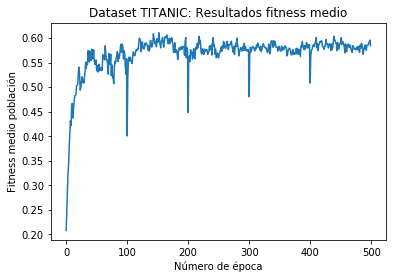

In [26]:
plt.title('Dataset TITANIC: Resultados fitness medio')
plt.ylabel('Fitness medio población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_titanic.mean_fitness_evol)), best_sol_titanic.mean_fitness_evol)

Como podemos apreciar, cuando acaba el entrenamiento en un *fold* se ejecuta un nuevo entrenamiento en el siguiente, reejecutando la inicialización aleatoria de la población inicial y de ahí esos bruscos bajones de *fitness* medio. No obstante, el *fitness* medio anterior se recupera rápidamente y podemos ver que **se va estancando cuando se acerca un máximo potencial entre el 0.55 y el 0.6**.

Ahora vamos a analizar sólo el ***fitness* medio del entrenamiento con el último *fold***, que se corresponde con la gráfica anterior entre las épocas 400 y 500.

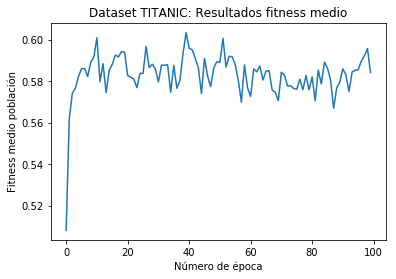

In [32]:
plt.title('Dataset TITANIC: Resultados fitness medio')
plt.ylabel('Fitness medio población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_titanic.mean_fitness_evol[400:])), best_sol_titanic.mean_fitness_evol[400:])

Como podemos apreciar, el ***fitness* medio ha ido creciendo rápidamente en las primeras épocas**, pero **estancándose en las 80 últimas épocas entre 0.58 y 0.60**. Esto no tiene por qué ser malo del todo, ya que con la **aproximación *Pittsburgh*** buscamos optimizar el mejor individuo de la población, y no la población en general. Buscamos que en el conjunto poblacional haya la mayor diversidad posible, intentando buscar nuevos individuos con un *fitness* excelente.

Ahora precisamente **vamos a estudiar el mejor *fitness* época tras época**. Como hemos comentado antes, mostraremos dos gráficas, **la primera** dónde se podrán observar todas las épocas tras la validación cruzada **con 5 *folds***, y otra con **sólo la última validación en el *fold* restante**.

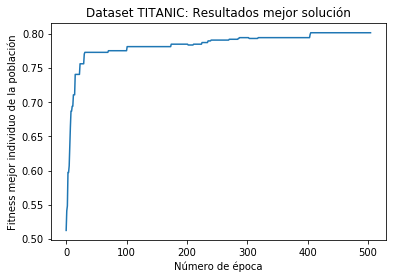

In [19]:
plt.title('Dataset TITANIC: Resultados mejor solución')
plt.ylabel('Fitness mejor individuo de la población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_titanic.best_fitness_evol)), best_sol_titanic.best_fitness_evol)

El ***fitness* del mejor individuo parece haber convergido a un máximo local rápidamente**. Observar que maximizar el *fitness* es equivalente a minimizar el error.

Tras la primera validación el algoritmo ha ido mejorando su rendimiento poco a poco gracias a los cruces y mutaciones de cada una de las épocas. El **elitismo**, como habíamos ya adelantado, **permite tener una tendencia creciente** en el *fitness* del mejor individuo.

Ahora vamos a **analizar la gráfica de la última validación**, es decir, de las últimas 100 épocas.

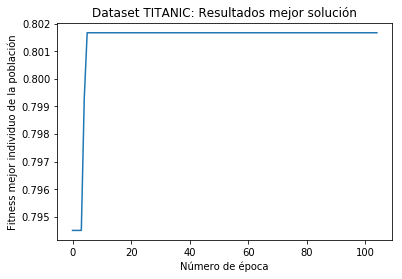

In [33]:
plt.title('Dataset TITANIC: Resultados mejor solución')
plt.ylabel('Fitness mejor individuo de la población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_titanic.best_fitness_evol[400:])), best_sol_titanic.best_fitness_evol[400:])

Vemos que es una generación poco interesante, ya que ya teníamos una muy buena solución después de las validaciones de los 4 *folds* anteriores. Notar que parece que entre las épocas 5 y 10 (aproximadamente) se generó a partir de los cruces y/o mutaciones un individuo mucho mejor que la mejor solución anterior, ya que la gráfica muestra un gran salto en esa parte de la evolución. Esta mejora espontánea es lo que precisamente se busca con la diversidad poblacional otorgada por los operadores genéticos: generar potenciales mejores individuos a partir de individuos con 'buen' *fitness* (decimos 'buen' *fitness* debido a que la probabilidad de seleccionar buenos individuos para el cruce son mayores que otros debido a la selección proporcional a *fitness* y, por supuesto, al elitismo).

Como en esta gráfica no podemos percibir la evolución inicial del mejor individuo, vamos a graficar la primera validación, es decir, **las primeras 100 épocas**.

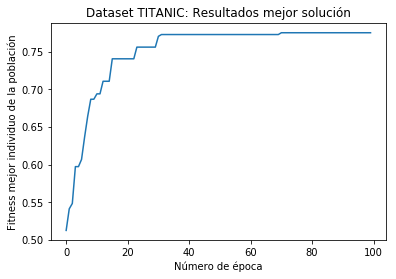

In [31]:
plt.title('Dataset TITANIC: Resultados mejor solución')
plt.ylabel('Fitness mejor individuo de la población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_titanic.best_fitness_evol[:100])), best_sol_titanic.best_fitness_evol[:100])

Esta gráfica es posiblemente más bonita que la anterior, donde podemos apreciar con mayor claridad la **mejora época tras época del mejor individuo de la población gracias a los diversos operadores genéticos y al elitismo**. El *fitness* del mejor individuo alcanza tras 30 épocas (aprox.) el 77% de precisión, y continuará ahí, mejorando poquito a poquito, por el resto de validaciones y épocas.

## <font color='blue'> 4.2 Conjunto de datos tic-tac-toe </font>

Recordemos que para este conjunto de datos **no hemos utilizado validación cruzada de 5 *folds***, sino **validación simple con dos repeticiones**. Por lo tanto, no tenemos 5 fases de entrenamiento, sino que **sólo tenemos dos**. Esto será fácil de observar en la gráfica del *fitness* medio poblacional, que será mostrada a continuación.

Comentar que como el clasificador con **mejores resultados fue entrenado con una población de 50 individuos y 200 épocas**, 2 repeticiones suponen unas 400 épocas totales, que aparecerán en el eje X de las gráficas (completas) que describirán el *fitness* medio y máximo.

Empecemos estudiando el ***fitness* medio de ambas repeticiones**.

In [8]:
best_sol_ttt = ttt_results_dict['clfGA_ttt_both_pop50_epoc200'][0]

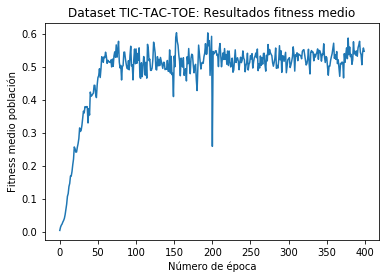

In [25]:
plt.title('Dataset TIC-TAC-TOE: Resultados fitness medio')
plt.ylabel('Fitness medio población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_ttt.mean_fitness_evol)), best_sol_ttt.mean_fitness_evol)

Como podemos apreciar, **tras 50-60 épocas el *fitness* medio de la población ya se situó sobre el 0.55% de precisión**, donde se quedará **oscilando** por el resto de épocas (salvo en la época 200, donde se reejecuta el entrenamiento y la función de generación de población aleatoria inicial).

Por otro lado, podemos **analizar la última repetición más en detalle**.

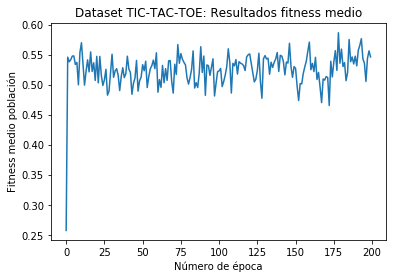

In [10]:
plt.title('Dataset TIC-TAC-TOE: Resultados fitness medio')
plt.ylabel('Fitness medio población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_ttt.mean_fitness_evol[200:])), best_sol_ttt.mean_fitness_evol[200:])

Vemos que **las últimas 200 épocas son parecidas a las dos primeras**, solo que **la convergencia a ese posible máximo local de precisión del 55% se ha realizado mucho más rápido** que en la repetición anterior, ya que ahora solo ha necesitado de un par de épocas. Por el resto del algoritmo el modelo ha ido subiendo y bajando utilizando los operadores genéticos para crear nuevas posibles buenas soluciones.

El trabajo importante se encuentra en las gráficas del mejor individuo, donde se aprecia el esfuerzo del clasificador por mejorar.

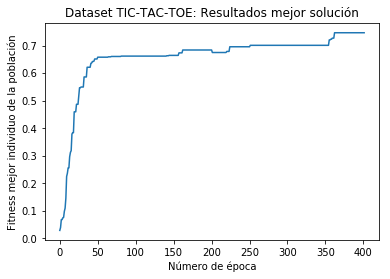

In [24]:
plt.title('Dataset TIC-TAC-TOE: Resultados mejor solución')
plt.ylabel('Fitness mejor individuo de la población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_ttt.best_fitness_evol)), best_sol_ttt.best_fitness_evol)

Como podemos percibir, el clasificador **ha ido generando nuevos buenos individuos rápidamente durante las primeras 50** épocas. A partir de ahí, ha ido **poco a poco creando mejores individuos** hasta posicionarse por encima del **75% de precisión**. 

Como es complicado observar la última fase del entrenamiento vamos a analizar más de cerca la última repetición de la validación simple.

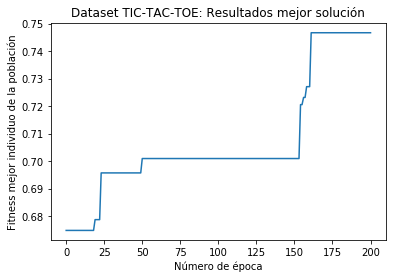

In [12]:
plt.title('Dataset TIC-TAC-TOE: Resultados mejor solución')
plt.ylabel('Fitness mejor individuo de la población')
plt.xlabel('Número de época')
plt.plot(range(len(best_sol_ttt.best_fitness_evol[201:])), best_sol_ttt.best_fitness_evol[201:])

Esta gráfica tiene su encanto, ya que podemos **apreciar la constante mejora del modelo**, buscando **nuevos mejores individuos cruzando/mutando los anteriores**. En las épocas **25, 50, 150 y ~160 se realizaron cambios muy fructíferos**, ya que la gráfica del mejor *fitness* pega saltos considerables. Nos preguntamos ahora qué hubiese pasado si en lugar de detener la ejecución del entrenamiento hubiésemos seguido evolucionando la población. Posiblemente hubiese mejorado un poco, pero siendo sinceros, tras ver todas las ejecuciones anteriores, este *dataset* iba a ser díficil de **aproximar mejor que un 75%** (en entrenamiento, en validación baja porque son ejemplos 'nuevos').

# <font color='red'>5. Análisis ROC: NaiveBayes vs AlgoritmoGenetico </font>

Vamos a recuperar las funciones para el análisis ROC que veníamos usando en las prácticas anteriores.

In [12]:
def create_confMatrix(pred, real):
    i = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for pred_val in pred:
        # True negative
        if pred_val==0 and pred_val==real[i]:
            tn += 1
        # False negative
        elif pred_val==0 and pred_val!=real[i]:
            fn += 1
        # True positive
        elif pred_val==1 and pred_val==real[i]:
            tp += 1
        # False positive
        elif pred_val==1 and pred_val!=real[i]:
            fp += 1
        i += 1
    
    return [['PRED POS', tp, fp], ['PRED NEG', fn, tn]]




def print_confMatrix(m):
    headers = ["", "REAL POS", "REAL NEG"]
    print(tabulate(m, headers, tablefmt="grid")) 

In [18]:
def ROC_Analysis(dataset, clf, particionado, print_confMtx=True):
    seed = random.seed(0)
    np.random.shuffle(dataset.datos)
    particionado.creaParticiones(dataset.datos, seed)
    
    TPRs = [] # True positive ratios
    FPRs = [] # False positive ratios
    for particion in particionado.particiones:

        datostrain = dataset.datos[particion.indicesTrain, :]
        datostest = dataset.datos[particion.indicesTest, :]
            
        clf.entrenamiento(datostrain, dataset.nominalAtributos, dataset.diccionario)
            
        pred = clf.clasifica(datostest, dataset.nominalAtributos, dataset.diccionario)
        real = datostest[:,-1] 
        
        # Creating confusion matrix, calculating TPR and FPR.
        m = create_confMatrix(pred, real)
        tpr_aux = m[0][1]/(m[0][1] + m[1][1])
        fpr_aux = m[0][2]/(m[0][2] + m[1][2])
        TPRs.append(tpr_aux)
        FPRs.append(fpr_aux)
    
    # Calculating TPRs and FPRs mean
    tpr = np.mean(TPRs)
    fpr = np.mean(FPRs)
    
    # Printing confusion matrix (if we want to)
    if print_confMtx:
        print_confMatrix(m)
        print("Punto espacio ROC: (", fpr, ",", tpr, ")")

    return fpr, tpr

In [19]:
def plot_ROC(fpr, tpr, clf_name=None, dataset_name=None):
    plt.figure()
    
    rand_bins = np.linspace(0, 1, num=30)
    plt.plot(rand_bins, rand_bins, color='blue', linestyle='dashed', label='random clf')
    
    tpr_coords = [0, tpr, 1]
    fpr_coords = [0, fpr, 1]
    plt.plot(fpr_coords, tpr_coords, color='red', label='classifier')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    if clf_name:
        plt.title('ROC space for '+clf_name)
    if dataset_name:
        plt.suptitle('Dataset used: '+dataset_name)
    else:
        plt.title('ROC space')

## <font color='blue'> 5.1 Conjunto de datos titanic </font>

Como el tiempo de entrenamiento es desorbitado si utilizamos el algoritmo genético, vamos a utilizar una estrategia de particionado simple y los hiperparámetros que mejor resultado nos han dado, los cuales podemos ver en la sección 3, pero que recordamos a continuación:
    - Estrategia de cruce: 'both'
    - Número de individuos: 150
    - Número de épocas: 100
    - Número máximo de reglas: 10
    - Probabilidad de cruce: 0.6
    - Probabilidad de mutación *bitflip*: None, es decir, en media 1 bit por regla.
    - Probabilidad de mutación de adición/eliminación de una regla: 0.25
    - Embarajamiento de reglas: True, es decir, el orden de las reglas no importa.

In [15]:
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)

In [20]:
ga = Clasificador.AlgoritmoGenetico(
        n_population=150,
        max_rules=10,
        nepochs=100,
        cross_prob=0.6,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.25,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

In [21]:
fpr, tpr = ROC_Analysis(db_titanic, ga, part_strat)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         65 |         11 |
+----------+------------+------------+
| PRED NEG |         32 |        102 |
+----------+------------+------------+
Punto espacio ROC: ( 0.09734513274336283 , 0.6701030927835051 )


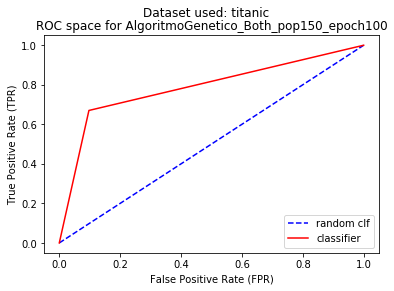

In [22]:
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop150_epoch100', dataset_name='titanic')

In [37]:
print('Error cometido:', (11+32)/(65+11+32+102))

Error cometido: 0.20476190476190476


Vemos que hemos vuelto a conseguir un ~80% de precisión en el *dataset* titanic. Podemos notar que el ratio de falsos positivos es de los más bajos conseguidos en las prácticas de esta asignatura, solo superado por el *dataset* WDBC de la práctica pasada. Por el co ntrario, el ratio de verdaderos posotivos no es excesivamente alto, de ahí que al final resulte en un 20% de error medio.

Vamos a ejecutar el mismo conjunto de entrenamiento pero usando ahora el clasificador Naive-Bayes.

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         59 |         19 |
+----------+------------+------------+
| PRED NEG |         22 |        110 |
+----------+------------+------------+
Punto espacio ROC: ( 0.14728682170542637 , 0.7283950617283951 )


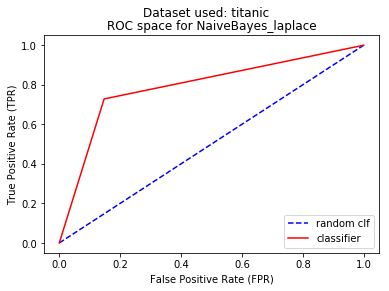

In [35]:
db_titanic_noOHE = Datos('../ConjuntosDatos/titanic.data', col_custom_dtypes={'Pclass':str, 'Age':str, 'Class':str})

# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
NB = Clasificador.ClasificadorNaiveBayes(laplace=True)

# ROC Análisis
fpr, tpr = ROC_Analysis(db_titanic_noOHE, NB, part_strat)
plot_ROC(fpr, tpr, clf_name='NaiveBayes_laplace', dataset_name='titanic')

In [38]:
print('Error cometido:', (22+19)/(22+19+59+110))

Error cometido: 0.19523809523809524


El error medio cometido es ligeramente inferior, entre 19-20%. Adicionalmente, el ratio de verdaderos positivos pero, en contraposición, el ratio de falsos positivos es cosiderablemente superior.

Ahora es cuando nosotros debemos tener en cuenta los costes de mala clasificación. En este caso estamos tratando con un conjunto de entrenamiento de estadísticas de muertes/superiviventes de la tragedia del *titanic*. Ajustar bien este *dataset* no va mucho más allá de la práctica de estos algoritmos, por lo que podemos considerar los costes de mala clasificación iguales, y centrar nuestros esfuerzos en maximizar el área bajo la curva ROC. En este caso tendríamos que darle el punto al clasificador Naive-Bayes, que es el que consigue el menor error, por poco, pero menor.

Sin embargo, si quisiésemos expandir el ejemplo del titanic para mejorar los diseños de los barcos actuales y hacerlos lo más 'evacuables' posibles (u otra medida de calidad de seguridad en caso de naufragio), nos interesaría minimizar la cantidad de falsos positivos, ya que si basamos las mejoras de seguridad en un modelo con un ratio de falsos positivos muy alto, estas van a ser poco efectivas. Observemos que si el ratio de falsos positivos, en este caso, sería la cantidad de personas que predecimos que sobreviven pero en realidad no lo hacen. De ahí que prefiramos un modelo con FPR muy bajo si deseásemos basar nuestras mejoras de seguridad de los barcos actuales en las predicciones de ese modelo. En esta última situación, deberíamos escoger la solución aportada por el algoritmo genético frente a la del clasificador Naive-Bayes, ya que su FPR es menor.

## <font color='blue'> 5.2 Conjunto de datos tic-tac-toe </font>

De nuevo, como el tiempo de entrenamiento es desorbitado para el algoritmo genético, vamos a utilizar una estrategia de particionado simple y los hiperparámetros que mejor resultado nos han dado, los cuales podemos ver en la sección 3, pero que recordamos a continuación:
    - Estrategia de cruce: 'both'
    - Número de individuos: 50
    - Número de épocas: 200
    - Número máximo de reglas: 7
    - Probabilidad de cruce: 0.4
    - Probabilidad de mutación *bitflip*: None, es decir, en media 1 bit por regla.
    - Probabilidad de mutación de adición/eliminación de una regla: 0.3
    - Embarajamiento de reglas: True, es decir, el orden de las reglas no importa.

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        116 |         74 |
+----------+------------+------------+
| PRED NEG |          0 |          2 |
+----------+------------+------------+
Punto espacio ROC: ( 0.9736842105263158 , 1.0 )


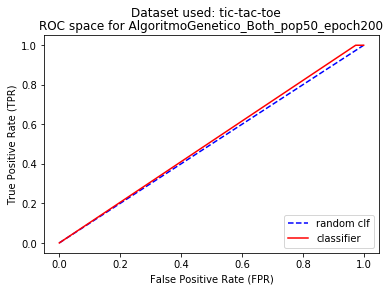

In [46]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

In [47]:
print('Error cometido:', (0+74)/(74+2+116))

Error cometido: 0.3854166666666667


+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        118 |         74 |
+----------+------------+------------+
| PRED NEG |          0 |          0 |
+----------+------------+------------+
Punto espacio ROC: ( 1.0 , 1.0 )


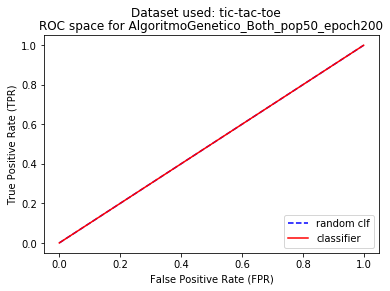

In [48]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        129 |         62 |
+----------+------------+------------+
| PRED NEG |          1 |          0 |
+----------+------------+------------+
Punto espacio ROC: ( 1.0 , 0.9923076923076923 )


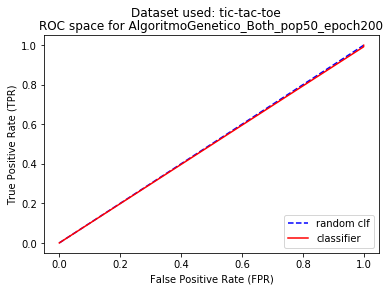

In [49]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        133 |         59 |
+----------+------------+------------+
| PRED NEG |          0 |          0 |
+----------+------------+------------+
Punto espacio ROC: ( 1.0 , 1.0 )


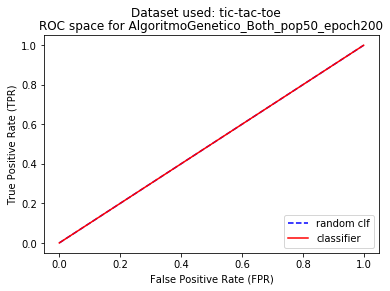

In [50]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        114 |         78 |
+----------+------------+------------+
| PRED NEG |          0 |          0 |
+----------+------------+------------+
Punto espacio ROC: ( 1.0 , 1.0 )


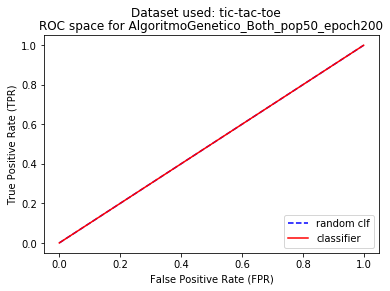

In [52]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        111 |         72 |
+----------+------------+------------+
| PRED NEG |          6 |          3 |
+----------+------------+------------+
Punto espacio ROC: ( 0.96 , 0.9487179487179487 )


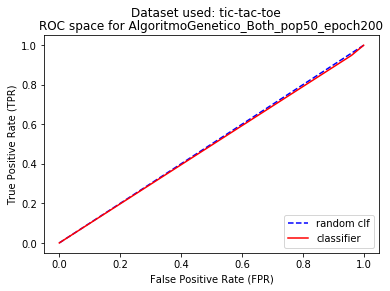

In [53]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        114 |         78 |
+----------+------------+------------+
| PRED NEG |          0 |          0 |
+----------+------------+------------+
Punto espacio ROC: ( 1.0 , 1.0 )


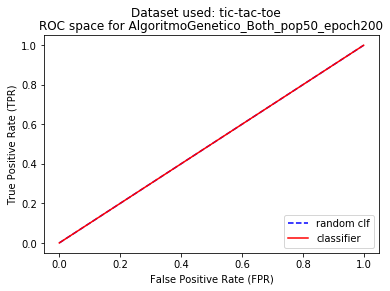

In [55]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        110 |         28 |
+----------+------------+------------+
| PRED NEG |         30 |         24 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5384615384615384 , 0.7857142857142857 )


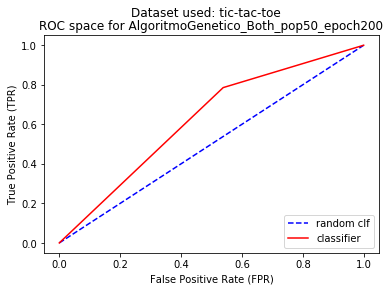

In [56]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='both',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        130 |         62 |
+----------+------------+------------+
| PRED NEG |          0 |          0 |
+----------+------------+------------+
Punto espacio ROC: ( 1.0 , 1.0 )


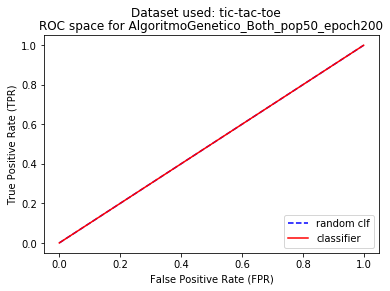

In [60]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='uniform',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        128 |         64 |
+----------+------------+------------+
| PRED NEG |          0 |          0 |
+----------+------------+------------+
Punto espacio ROC: ( 1.0 , 1.0 )


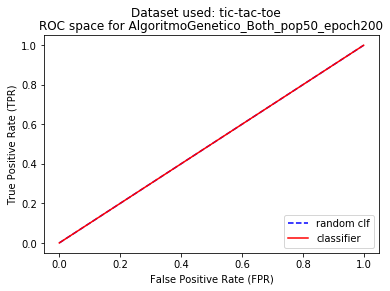

In [59]:
# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
ga = Clasificador.AlgoritmoGenetico(
        n_population=50,
        max_rules=7,
        nepochs=200,
        cross_prob=0.4,
        cross_strat='uniform',
        bitflip_prob=None,
        add_rule_prob=0.3,
        elite_perc=0.05,
        shuffle_rules=True,
        verbose=False
    )

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt, ga, part_strat)
plot_ROC(fpr, tpr, clf_name='AlgoritmoGenetico_Both_pop50_epoch200', dataset_name='tic-tac-toe')

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        108 |         34 |
+----------+------------+------------+
| PRED NEG |         21 |         29 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5396825396825397 , 0.8372093023255814 )


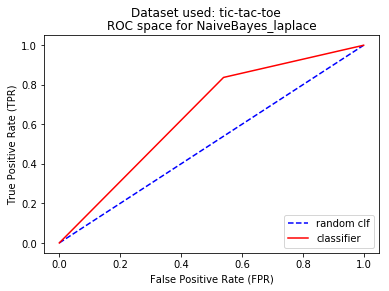

In [45]:
db_ttt_noOHE = Datos('../ConjuntosDatos/tic-tac-toe.data', col_custom_dtypes={'class':str})

# Partición + Clasificador
part_strat = EstrategiaParticionado.ValidacionSimple(percentage=0.8)
NB = Clasificador.ClasificadorNaiveBayes(laplace=True)

# ROC Análisis
fpr, tpr = ROC_Analysis(db_ttt_noOHE, NB, part_strat)
plot_ROC(fpr, tpr, clf_name='NaiveBayes_laplace', dataset_name='tic-tac-toe')

In [51]:
print('Error cometido:', (34+21)/(34+21+108+29))

Error cometido: 0.2864583333333333
